# Patient Survival Prediction

In [1]:
#!pip install -r requirements.txt

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, AdaBoostClassifier, GradientBoostingClassifier, VotingClassifier, BaggingClassifier 
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from lightgbm import LGBMClassifier

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K

from sklearn import preprocessing
from scipy.stats import chi2_contingency
from scipy.stats import chisquare
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.utils import resample
from sklearn.model_selection import RandomizedSearchCV
import shap

import pickle

In [2]:
np.random.seed(12345)

## Data Loading

In [3]:
dataset = pd.read_csv('dataset.csv')

## Examining the Data

In [4]:
dataset

encounter_id  patient_id  hospital_id   age        bmi  \
0             66154       25312          118  68.0  22.730000   
1            114252       59342           81  77.0  27.420000   
2            119783       50777          118  25.0  31.950000   
3             79267       46918          118  81.0  22.640000   
4             92056       34377           33  19.0        NaN   
...             ...         ...          ...   ...        ...   
91708         91592       78108           30  75.0  23.060250   
91709         66119       13486          121  56.0  47.179671   
91710          8981       58179          195  48.0  27.236914   
91711         33776      120598           66   NaN  23.297481   
91712          1671       53612          104  82.0  22.031250   

       elective_surgery  ethnicity gender  height           icu_admit_source  \
0                     0  Caucasian      M   180.3                      Floor   
1                     0  Caucasian      F   160.0                      Floor   
2                     0  Caucasian      F   172.7       Accident & Emergency   
3                     1  Caucasian      F   165.1  Operating Room / Recovery   
4                     0  Caucasian      M   188.0       Accident & Emergency   
...                 ...        ...    ...     ...                        ...   
91708                 0  Caucasian      M   177.8                      Floor   
91709                 0  Caucasian      F   183.0                      Floor   
91710                 0  Caucasian      M   170.2       Accident & Emergency   
91711                 0  Caucasian      F   154.9       Accident & Emergency   
91712                 1  Caucasian      F   160.0  Operating Room / Recovery   

       ...  diabetes_mellitus hepatic_failure immunosuppression  leukemia  \
0      ...                1.0             0.0               0.0       0.0   
1      ...                1.0             0.0               0.0       0.0   
2      ...                0.0             0.0               0.0       0.0   
3      ...                0.0             0.0               0.0       0.0   
4      ...                0.0             0.0               0.0       0.0   
...    ...                ...             ...               ...       ...   
91708  ...                1.0             0.0               0.0       0.0   
91709  ...                0.0             0.0               0.0       0.0   
91710  ...                1.0             0.0               0.0       0.0   
91711  ...                0.0             0.0               0.0       0.0   
91712  ...                0.0             0.0               0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
2           0.0                          0.0             Metabolic   
3           0.0                          0.0        Cardiovascular   
4           0.0                          0.0                Trauma   
...         ...                          ...                   ...   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91710       0.0                          0.0             Metabolic   
91711       0.0                          0.0           Respiratory   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  Unnamed: 83  hospital_death  
0           Cardiovascular          NaN               0  
1              Respiratory          NaN               0  
2                Metabolic          NaN               0  
3           Cardiovascular          NaN               0  
4                   Trauma          NaN               0  
...                    ...          ...             ...  
91708       Cardiovascular          NaN               0  
91709       Cardiovascular         

In [5]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 85 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   encounter_id                   91713 non-null  int64  
 1   patient_id                     91713 non-null  int64  
 2   hospital_id                    91713 non-null  int64  
 3   age                            87485 non-null  float64
 4   bmi                            88284 non-null  float64
 5   elective_surgery               91713 non-null  int64  
 6   ethnicity                      90318 non-null  object 
 7   gender                         91688 non-null  object 
 8   height                         90379 non-null  float64
 9   icu_admit_source               91601 non-null  object 
 10  icu_id                         91713 non-null  int64  
 11  icu_stay_type                  91713 non-null  object 
 12  icu_type                       91713 non-null 

The data types that are used are either one of these: int64, float64, object. Also, from the "Non-Null Count", it can be seen that there are null values in almost all of the columns.

Now, let us examine the data in two parts: numeric part and non-numeric part.

In [6]:
categorical_dataset = dataset.select_dtypes("object")
numeric_dataset = dataset.select_dtypes(exclude=["object"])

In [7]:
categorical_dataset

ethnicity gender           icu_admit_source icu_stay_type  \
0      Caucasian      M                      Floor         admit   
1      Caucasian      F                      Floor         admit   
2      Caucasian      F       Accident & Emergency         admit   
3      Caucasian      F  Operating Room / Recovery         admit   
4      Caucasian      M       Accident & Emergency         admit   
...          ...    ...                        ...           ...   
91708  Caucasian      M                      Floor         admit   
91709  Caucasian      F                      Floor         admit   
91710  Caucasian      M       Accident & Emergency         admit   
91711  Caucasian      F       Accident & Emergency         admit   
91712  Caucasian      F  Operating Room / Recovery         admit   

           icu_type apache_3j_bodysystem apache_2_bodysystem  
0             CTICU               Sepsis      Cardiovascular  
1      Med-Surg ICU          Respiratory         Respiratory  
2      Med-Surg ICU            Metabolic           Metabolic  
3             CTICU       Cardiovascular      Cardiovascular  
4      Med-Surg ICU               Trauma              Trauma  
...             ...                  ...                 ...  
91708   Cardiac ICU               Sepsis      Cardiovascular  
91709  Med-Surg ICU               Sepsis      Cardiovascular  
91710  Med-Surg ICU            Metabolic           Metabolic  
91711  Med-Surg ICU          Respiratory         Respiratory  
91712  Med-Surg ICU     Gastrointestinal    Gastrointestinal  

[91713 rows x 7 columns]

In [8]:
numeric_dataset

encounter_id  patient_id  hospital_id   age        bmi  \
0             66154       25312          118  68.0  22.730000   
1            114252       59342           81  77.0  27.420000   
2            119783       50777          118  25.0  31.950000   
3             79267       46918          118  81.0  22.640000   
4             92056       34377           33  19.0        NaN   
...             ...         ...          ...   ...        ...   
91708         91592       78108           30  75.0  23.060250   
91709         66119       13486          121  56.0  47.179671   
91710          8981       58179          195  48.0  27.236914   
91711         33776      120598           66   NaN  23.297481   
91712          1671       53612          104  82.0  22.031250   

       elective_surgery  height  icu_id  pre_icu_los_days  weight  ...  aids  \
0                     0   180.3      92          0.541667    73.9  ...   0.0   
1                     0   160.0      90          0.927778    70.2  ...   0.0   
2                     0   172.7      93          0.000694    95.3  ...   0.0   
3                     1   165.1      92          0.000694    61.7  ...   0.0   
4                     0   188.0      91          0.073611     NaN  ...   0.0   
...                 ...     ...     ...               ...     ...  ...   ...   
91708                 0   177.8     927          0.298611    72.9  ...   0.0   
91709                 0   183.0     925          0.120139   158.0  ...   0.0   
91710                 0   170.2     908          0.046528    78.9  ...   0.0   
91711                 0   154.9     922          0.081944    55.9  ...   0.0   
91712                 1   160.0     926          0.018056    56.4  ...   0.0   

       cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
0            0.0                1.0              0.0                0.0   
1            0.0                1.0              0.0                0.0   
2            0.0                0.0              0.0                0.0   
3            0.0                0.0              0.0                0.0   
4            0.0                0.0              0.0                0.0   
...          ...                ...              ...                ...   
91708        0.0                1.0              0.0                0.0   
91709        0.0                0.0              0.0                0.0   
91710        0.0                1.0              0.0                0.0   
91711        0.0                0.0              0.0                0.0   
91712        0.0                0.0              0.0                0.0   

       leukemia  lymphoma  solid_tumor_with_metastasis  Unnamed: 83  \
0           0.0       0.0                          0.0          NaN   
1           0.0       0.0                          0.0          NaN   
2           0.0       0.0                          0.0          NaN   
3           0.0       0.0                          0.0          NaN   
4           0.0       0.0                          0.0          NaN   
...         ...       ...                          ...          ...   
91708       0.0       0.0                          1.0          NaN   
91709       0.0       0.0                          0.0          NaN   
91710       0.0       0.0                          0.0          NaN   
91711       0.0       0.0                          0.0          NaN   
91712       0.0       0.0                          0.0          NaN   

       hospital_death  
0                   0  
1                   0  
2                   0  
3                   0  
4                   0  
...               ...  
91708               0  
91709               0  
91710               0  
91711               0  
91712               0  

[91713 rows x 78 columns]

All the data are divided correctly since originally 85 columns exist and numeric ones have 78, categorical ones have 7 columns.

### Categoric Data Examination

In [9]:
categorical_dataset.describe()

ethnicity gender      icu_admit_source icu_stay_type      icu_type  \
count       90318  91688                 91601         91713         91713   
unique          6      2                     5             3             8   
top     Caucasian      M  Accident & Emergency         admit  Med-Surg ICU   
freq        70684  49469                 54060         86183         50586   

       apache_3j_bodysystem apache_2_bodysystem  
count                 90051               90051  
unique                   11                  10  
top          Cardiovascular      Cardiovascular  
freq                  29999               38816

From "count" column, we know the columns that contain no null values are "icu_type" and "icu_stay_type". Aside from these, the others contain null values no more than 2000.

From "unique" column, it is understood that there are no one-valued column that can be dropped.

Let us see the most frequent value's percentile for each column.

In [10]:
frequencies = categorical_dataset.describe().loc["freq"] / categorical_dataset.describe().loc["count"]
frequency_categorical = pd.DataFrame(frequencies).transpose().rename(index={0:'freq'})  #so that the indexes can be columns
frequency_categorical

ethnicity    gender icu_admit_source icu_stay_type  icu_type  \
freq  0.782613  0.539536         0.590168      0.939703  0.551568   

     apache_3j_bodysystem apache_2_bodysystem  
freq             0.333133            0.431045

The percentages of "ethnicity" and "icu_stay_type" show us that these values may not be distributed balanced. So, methods such as bootstrap may work for this case.

In [11]:
frequency_tops = frequency_categorical.append(categorical_dataset.describe().loc["top"])
frequency_tops

ethnicity    gender      icu_admit_source icu_stay_type      icu_type  \
freq   0.782613  0.539536              0.590168      0.939703      0.551568   
top   Caucasian         M  Accident & Emergency         admit  Med-Surg ICU   

     apache_3j_bodysystem apache_2_bodysystem  
freq             0.333133            0.431045  
top        Cardiovascular      Cardiovascular

Lastly, let us see the unique values of each column.

In [12]:
for column in categorical_dataset:
    print(column , categorical_dataset[column].unique())

ethnicity ['Caucasian' nan 'Hispanic' 'African American' 'Asian' 'Native American'
 'Other/Unknown']
gender ['M' 'F' nan]
icu_admit_source ['Floor' 'Accident & Emergency' 'Operating Room / Recovery'
 'Other Hospital' 'Other ICU' nan]
icu_stay_type ['admit' 'readmit' 'transfer']
icu_type ['CTICU' 'Med-Surg ICU' 'CCU-CTICU' 'Neuro ICU' 'MICU' 'SICU'
 'Cardiac ICU' 'CSICU']
apache_3j_bodysystem ['Sepsis' 'Respiratory' 'Metabolic' 'Cardiovascular' 'Trauma'
 'Neurological' 'Gastrointestinal' 'Genitourinary' nan 'Hematological'
 'Musculoskeletal/Skin' 'Gynecological']
apache_2_bodysystem ['Cardiovascular' 'Respiratory' 'Metabolic' 'Trauma' 'Neurologic'
 'Gastrointestinal' 'Renal/Genitourinary' nan 'Undefined diagnoses'
 'Haematologic' 'Undefined Diagnoses']


Let us see the distribution of the categorical data.

Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data

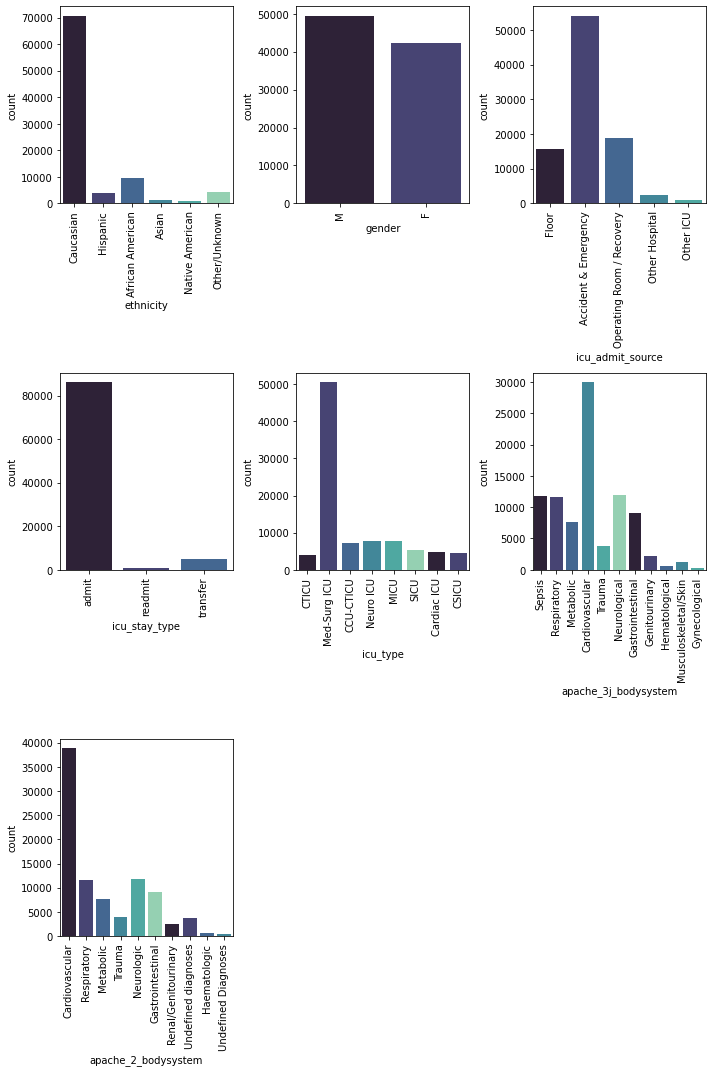

In [13]:
fig,axes = plt.subplots(3,3)
fig.set_figheight(15)
fig.set_figwidth(10)
for i in range(len(categorical_dataset.columns)):
    row = i // 3
    col = i % 3
    plot = sns.countplot(categorical_dataset[categorical_dataset.columns[i]] , palette=sns.color_palette("mako") ,  orient="h" , ax=axes[row,col])
    plot.set_xticklabels(plot.get_xticklabels() , rotation=90)

fig.delaxes(axes[2,1])
fig.delaxes(axes[2,2])
fig.tight_layout()

As it can be seen from these plots, there are dominant properties in each feature except for gender. For example when ethnicity is examined, most of the patients are Caucasian. Let us see the count of each value for each feature.

In [14]:
for col in categorical_dataset.columns:
    print(categorical_dataset[col].value_counts() , "\n")

Caucasian           70684
African American     9547
Other/Unknown        4374
Hispanic             3796
Asian                1129
Native American       788
Name: ethnicity, dtype: int64 

M    49469
F    42219
Name: gender, dtype: int64 

Accident & Emergency         54060
Operating Room / Recovery    18713
Floor                        15611
Other Hospital                2358
Other ICU                      859
Name: icu_admit_source, dtype: int64 

admit       86183
transfer     4970
readmit       560
Name: icu_stay_type, dtype: int64 

Med-Surg ICU    50586
MICU             7695
Neuro ICU        7675
CCU-CTICU        7156
SICU             5209
Cardiac ICU      4776
CSICU            4613
CTICU            4003
Name: icu_type, dtype: int64 

Cardiovascular          29999
Neurological            11896
Sepsis                  11740
Respiratory             11609
Gastrointestinal         9026
Metabolic                7650
Trauma                   3842
Genitourinary            2172
Musculoske

## Numeric Data Examination

In [15]:
numeric_dataset.describe()

encounter_id     patient_id   hospital_id           age           bmi  \
count   91713.000000   91713.000000  91713.000000  87485.000000  88284.000000   
mean    65606.079280   65537.131464    105.669262     62.309516     29.185818   
std     37795.088538   37811.252183     62.854406     16.775119      8.275142   
min         1.000000       1.000000      2.000000     16.000000     14.844926   
25%     32852.000000   32830.000000     47.000000     52.000000     23.641975   
50%     65665.000000   65413.000000    109.000000     65.000000     27.654655   
75%     98342.000000   98298.000000    161.000000     75.000000     32.930206   
max    131051.000000  131051.000000    204.000000     89.000000     67.814990   

       elective_surgery        height        icu_id  pre_icu_los_days  \
count      91713.000000  90379.000000  91713.000000      91713.000000   
mean           0.183736    169.641588    508.357692          0.835766   
std            0.387271     10.795378    228.989661          2.487756   
min            0.000000    137.200000     82.000000        -24.947222   
25%            0.000000    162.500000    369.000000          0.035417   
50%            0.000000    170.100000    504.000000          0.138889   
75%            0.000000    177.800000    679.000000          0.409028   
max            1.000000    195.590000    927.000000        159.090972   

             weight  ...          aids     cirrhosis  diabetes_mellitus  \
count  88993.000000  ...  90998.000000  90998.000000       90998.000000   
mean      84.028340  ...      0.000857      0.015693           0.225192   
std       25.011497  ...      0.029265      0.124284           0.417711   
min       38.600000  ...      0.000000      0.000000           0.000000   
25%       66.800000  ...      0.000000      0.000000           0.000000   
50%       80.300000  ...      0.000000      0.000000           0.000000   
75%       97.100000  ...      0.000000      0.000000           0.000000   
max      186.000000  ...      1.000000      1.000000           1.000000   

       hepatic_failure  immunosuppression      leukemia      lymphoma  \
count     90998.000000       90998.000000  90998.000000  90998.000000   
mean          0.012989           0.026165      0.007066      0.004132   
std           0.113229           0.159628      0.083763      0.064148   
min           0.000000           0.000000      0.000000      0.000000   
25%           0.000000           0.000000      0.000000      0.000000   
50%           0.000000           0.000000      0.000000      0.000000   
75%           0.000000           0.000000      0.000000      0.000000   
max           1.000000           1.000000      1.000000      1.000000   

       solid_tumor_with_metastasis  Unnamed: 83  hospital_death  
count                 90998.000000          0.0    91713.000000  
mean                      0.020638          NaN        0.086302  
std                       0.142169          NaN        0.280811  
min                       0.000000          NaN        0.000000  
25%                       0.000000          NaN        0.000000  
50%                       0.000000          NaN        0.000000  
75%                       0.000000          NaN        0.000000  
max                       1.000000          NaN        1.000000  

[8 rows x 78 columns]

Let us find columns that are one-valued if any.

In [16]:
one_valued_cols = []
for col in numeric_dataset:
    if (numeric_dataset.describe()[col]["std"] == 0):
        one_valued_cols.append(col)
one_valued_cols

[]

There is no one-valued column. Then, let us show the standard deviation distribution of these columns in order to see if they need scaling or not:

In [17]:
numeric_std = pd.Series.sort_values(numeric_dataset.describe().loc["std"])
numeric_std

aids                       0.029265
lymphoma                   0.064148
leukemia                   0.083763
gcs_unable_apache          0.097148
hepatic_failure            0.113229
                           ...     
icu_id                   228.989661
apache_3j_diagnosis      463.266985
encounter_id           37795.088538
patient_id             37811.252183
Unnamed: 83                     NaN
Name: std, Length: 78, dtype: float64

Let us drop the column "Unnamed: 83" since it has only NaN values.

In [18]:
dataset.drop(["Unnamed: 83"] , axis=1 , inplace=True)
numeric_dataset.drop(["Unnamed: 83"] , axis=1 , inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Updating the std values accordingly (without the dropped column)

In [19]:
numeric_std = pd.Series.sort_values(numeric_dataset.describe().loc["std"])
numeric_std

aids                       0.029265
lymphoma                   0.064148
leukemia                   0.083763
gcs_unable_apache          0.097148
hepatic_failure            0.113229
                           ...     
d1_glucose_max            86.687955
icu_id                   228.989661
apache_3j_diagnosis      463.266985
encounter_id           37795.088538
patient_id             37811.252183
Name: std, Length: 77, dtype: float64

The columns "encounter_id" and "patient_id" are distinct values for each patient and it has nothing to do with our prediction. Thus, their standard deviations are really high. Let us drop them.

In [20]:
dataset.drop(["encounter_id" , "patient_id"] , axis=1 , inplace=True)
numeric_dataset.drop(["encounter_id" , "patient_id"] , axis=1 , inplace=True)
numeric_std = pd.Series.sort_values(numeric_dataset.describe().loc["std"])

(array([60., 10.,  1.,  2.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([2.92649343e-02, 2.31911509e+01, 4.63530369e+01, 6.95149229e+01,
        9.26768089e+01, 1.15838695e+02, 1.39000581e+02, 1.62162467e+02,
        1.85324353e+02, 2.08486239e+02, 2.31648125e+02, 2.54810011e+02,
        2.77971897e+02, 3.01133783e+02, 3.24295669e+02, 3.47457555e+02,
        3.70619441e+02, 3.93781327e+02, 4.16943213e+02, 4.40105099e+02,
        4.63266985e+02]),
 <BarContainer object of 20 artists>)

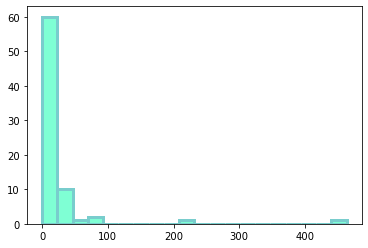

In [21]:
plt.hist(numeric_std , color="#7FFFD4" , ec="#79CDCD" , lw=3 , bins=20)

Most of the columns have standard deviation values that are smaller than 100. However, there are some with over 200 and even 400.

Let us compare the standard deviations of the columns that have the highest and the lowest standard deviation values.

In [22]:
pd.Series.sort_values(numeric_std , ascending=False)

apache_3j_diagnosis    463.266985
icu_id                 228.989661
d1_glucose_max          86.687955
apache_2_diagnosis      86.050882
hospital_id             62.854406
                          ...    
hepatic_failure          0.113229
gcs_unable_apache        0.097148
leukemia                 0.083763
lymphoma                 0.064148
aids                     0.029265
Name: std, Length: 75, dtype: float64

(array([9.092e+04, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 7.800e+01]),
 array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 <BarContainer object of 20 artists>)

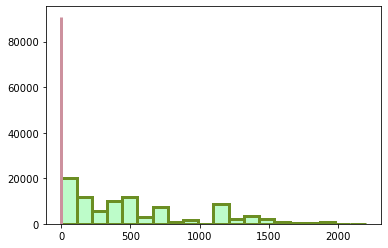

In [23]:
plt.hist(numeric_dataset["apache_3j_diagnosis"] , color="#BDFCC9" , ec="#6B8E23" , lw=3 , bins=20)
plt.hist(numeric_dataset["aids"] , color="#FFC0CB" , ec="#CD919E" , lw=3 , bins=20)

In order to balance this data, methods such as bootstrap is likely to be required.

Also, let us see the distribution of numeric data on histograms.

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


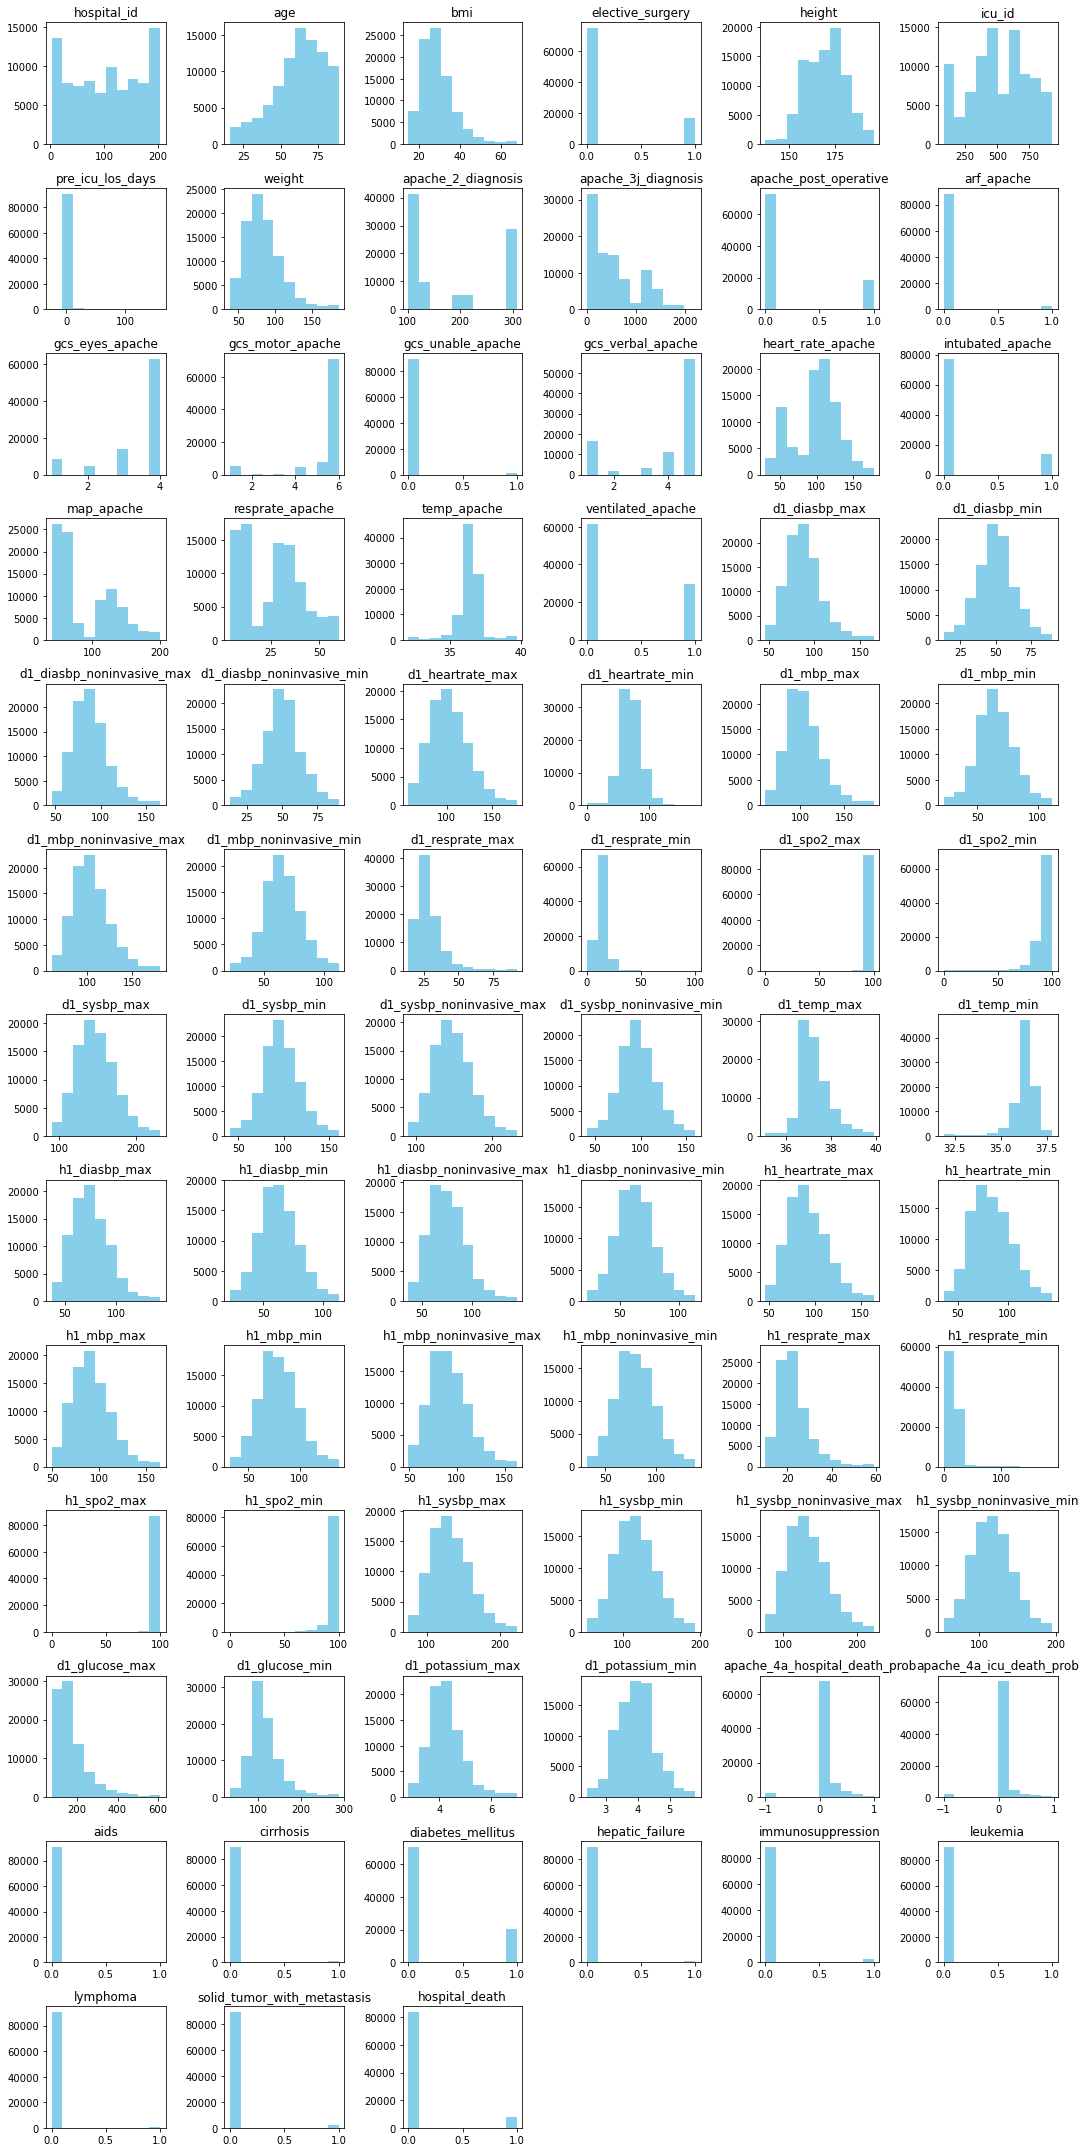

In [26]:
figure, axis = plt.subplots(13,6)
figure.set_figheight(30)
figure.set_figwidth(15)
for n in range(len(numeric_dataset.columns)):
    col = n % 6
    row = n // 6
    axis[row,col].hist(dataset[numeric_dataset.columns[n]], color = "skyblue", lw=0)
    axis[row,col].title.set_text(numeric_dataset.columns[n])
    figure.tight_layout()
figure.show()
figure.delaxes(axis[12,3])
figure.delaxes(axis[12,4])
figure.delaxes(axis[12,5])

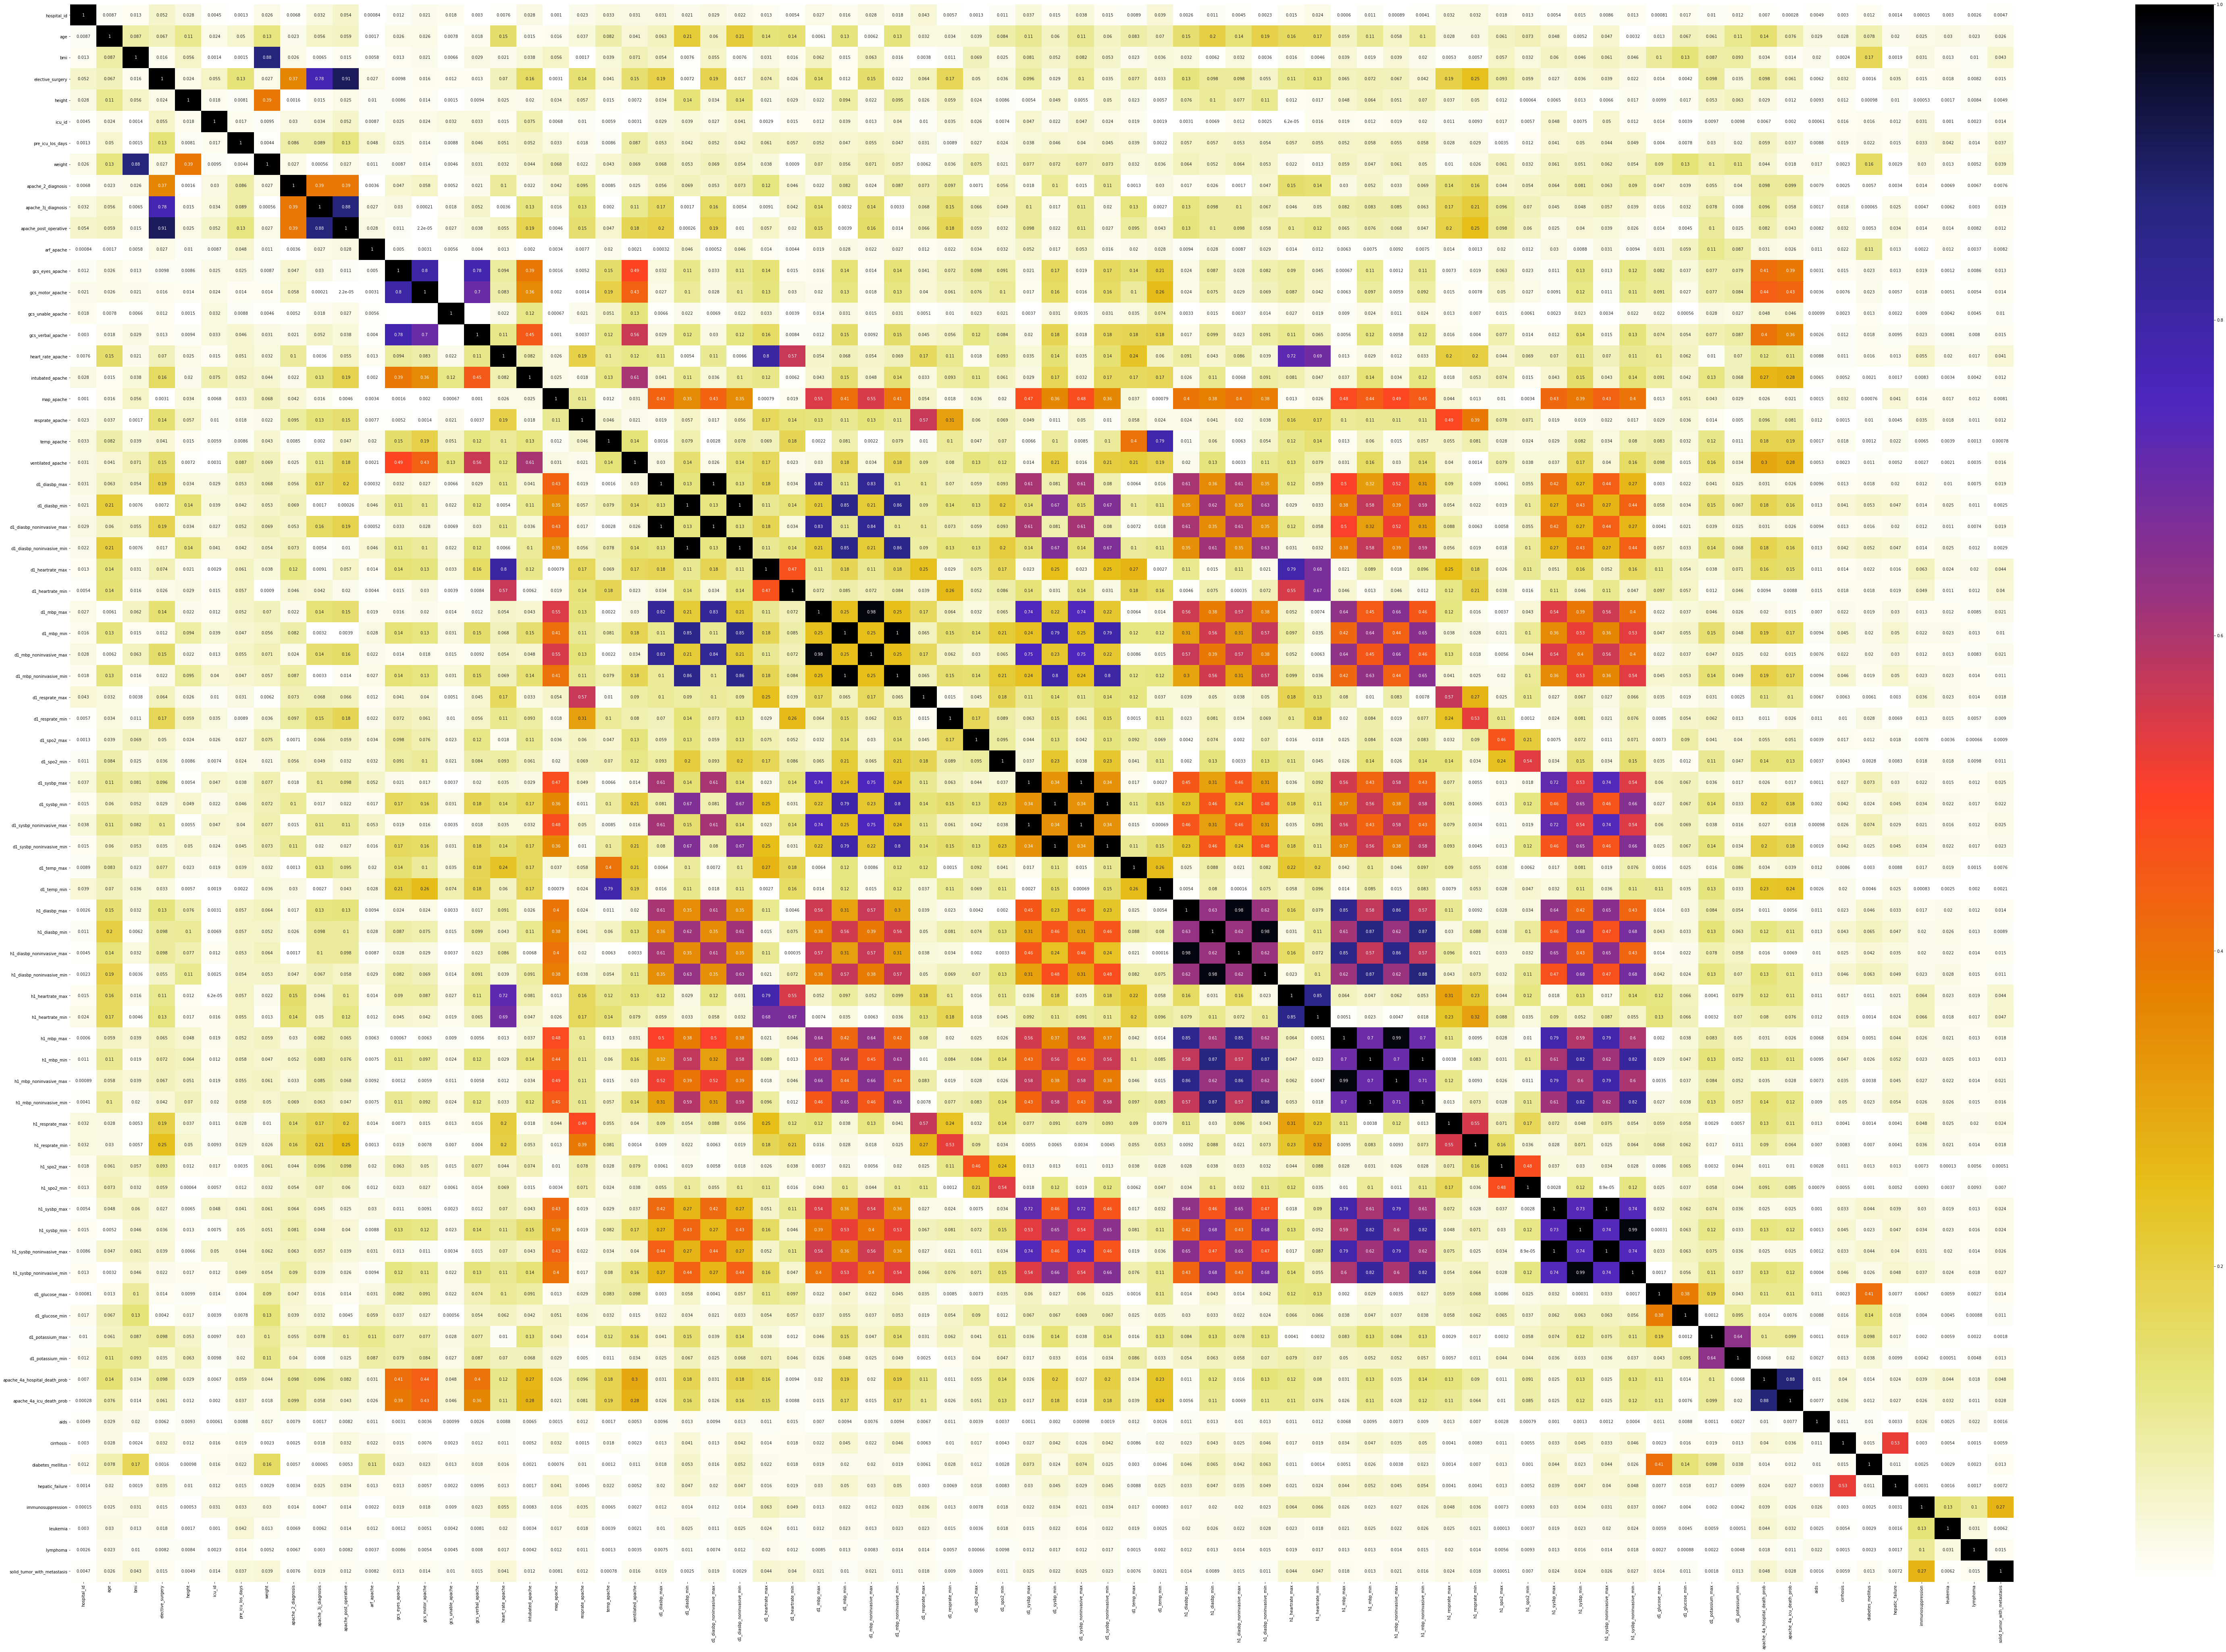

In [27]:
y = dataset["hospital_death"]
X = numeric_dataset.drop(['hospital_death'] , axis=1)
pearson_corr = X.corr().abs()
plt.figure(figsize=(108,72))
sns.heatmap(pearson_corr , cmap=plt.cm.CMRmap_r , annot=True)
plt.show()

As it is shown in the correlation table, there are many highly correlated columns that should be eliminated to one since they mean the same thing for the test and training results.

In [28]:
upper = pearson_corr.where(np.triu(np.ones(pearson_corr.shape), k=1).astype(np.bool))
to_drop = [column for column in upper.columns if any(upper[column] > 0.65) and any(upper[column] < 1)]
dataset.drop(to_drop, axis=1, inplace=True)

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [29]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hospital_id                    91713 non-null  int64  
 1   age                            87485 non-null  float64
 2   bmi                            88284 non-null  float64
 3   elective_surgery               91713 non-null  int64  
 4   ethnicity                      90318 non-null  object 
 5   gender                         91688 non-null  object 
 6   height                         90379 non-null  float64
 7   icu_admit_source               91601 non-null  object 
 8   icu_id                         91713 non-null  int64  
 9   icu_stay_type                  91713 non-null  object 
 10  icu_type                       91713 non-null  object 
 11  pre_icu_los_days               91713 non-null  float64
 12  apache_2_diagnosis             90051 non-null 

Let's convert categorical data into numerical before moving to clearing the null values.

In [30]:
categorical_features = dataset.select_dtypes(include="object").columns
label_encoder = preprocessing.LabelEncoder()
for i in range(len(categorical_features)):
    dataset[categorical_features[i]] = label_encoder.fit_transform(dataset[categorical_features[i]].astype(str))
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91713 entries, 0 to 91712
Data columns (total 52 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   hospital_id                    91713 non-null  int64  
 1   age                            87485 non-null  float64
 2   bmi                            88284 non-null  float64
 3   elective_surgery               91713 non-null  int64  
 4   ethnicity                      91713 non-null  int32  
 5   gender                         91713 non-null  int32  
 6   height                         90379 non-null  float64
 7   icu_admit_source               91713 non-null  int32  
 8   icu_id                         91713 non-null  int64  
 9   icu_stay_type                  91713 non-null  int32  
 10  icu_type                       91713 non-null  int32  
 11  pre_icu_los_days               91713 non-null  float64
 12  apache_2_diagnosis             90051 non-null 

In [31]:
dataset.isnull().sum().sort_values(ascending=True) #the columns that contains the most null values can be dropped

hospital_id                         0
apache_3j_bodysystem                0
apache_2_bodysystem                 0
pre_icu_los_days                    0
icu_type                            0
icu_stay_type                       0
icu_id                              0
hospital_death                      0
gender                              0
ethnicity                           0
elective_surgery                    0
icu_admit_source                    0
d1_heartrate_min                  145
d1_diasbp_min                     165
d1_diasbp_max                     165
d1_spo2_min                       333
d1_spo2_max                       333
d1_resprate_max                   385
d1_resprate_min                   385
diabetes_mellitus                 715
hepatic_failure                   715
immunosuppression                 715
leukemia                          715
cirrhosis                         715
intubated_apache                  715
lymphoma                          715
arf_apache  

In [32]:
dataset.shape

(91713, 52)

In [33]:
data_nulldropped = dataset.dropna()
data_nulldropped.shape  ##too much loss but might be useful

(61593, 52)

In [34]:
data_nulldropped.isnull().sum()

hospital_id                      0
age                              0
bmi                              0
elective_surgery                 0
ethnicity                        0
gender                           0
height                           0
icu_admit_source                 0
icu_id                           0
icu_stay_type                    0
icu_type                         0
pre_icu_los_days                 0
apache_2_diagnosis               0
arf_apache                       0
gcs_eyes_apache                  0
gcs_unable_apache                0
heart_rate_apache                0
intubated_apache                 0
map_apache                       0
resprate_apache                  0
temp_apache                      0
ventilated_apache                0
d1_diasbp_max                    0
d1_diasbp_min                    0
d1_heartrate_min                 0
d1_resprate_max                  0
d1_resprate_min                  0
d1_spo2_max                      0
d1_spo2_min         

In [35]:
dataset.groupby("hospital_death").count()

hospital_id    age    bmi  elective_surgery  ethnicity  \
hospital_death                                                           
0                     83798  80212  80732             83798      83798   
1                      7915   7273   7552              7915       7915   

                gender  height  icu_admit_source  icu_id  icu_stay_type  ...  \
hospital_death                                                           ...   
0                83798   82654             83798   83798          83798  ...   
1                 7915    7725              7915    7915           7915  ...   

                 aids  cirrhosis  diabetes_mellitus  hepatic_failure  \
hospital_death                                                         
0               83168      83168              83168            83168   
1                7830       7830               7830             7830   

                immunosuppression  leukemia  lymphoma  \
hospital_death                                          
0                           83168     83168     83168   
1                            7830      7830      7830   

                solid_tumor_with_metastasis  apache_3j_bodysystem  \
hospital_death                                                      
0                                     83168                 83798   
1                                      7830                  7915   

                apache_2_bodysystem  
hospital_death                       
0                             83798  
1                              7915  

[2 rows x 51 columns]

In [36]:
data_nulldropped.groupby("hospital_death").count()

hospital_id    age    bmi  elective_surgery  ethnicity  \
hospital_death                                                           
0                     56447  56447  56447             56447      56447   
1                      5146   5146   5146              5146       5146   

                gender  height  icu_admit_source  icu_id  icu_stay_type  ...  \
hospital_death                                                           ...   
0                56447   56447             56447   56447          56447  ...   
1                 5146    5146              5146    5146           5146  ...   

                 aids  cirrhosis  diabetes_mellitus  hepatic_failure  \
hospital_death                                                         
0               56447      56447              56447            56447   
1                5146       5146               5146             5146   

                immunosuppression  leukemia  lymphoma  \
hospital_death                                          
0                           56447     56447     56447   
1                            5146      5146      5146   

                solid_tumor_with_metastasis  apache_3j_bodysystem  \
hospital_death                                                      
0                                     56447                 56447   
1                                      5146                  5146   

                apache_2_bodysystem  
hospital_death                       
0                             56447  
1                              5146  

[2 rows x 51 columns]

After the correlated columns are dropped, the null values are checked. As there are approximately 92000 patients data in the dataset; instead of columns, the rows which contain null values are dropped to clear the data which caused the patient number to reduce to closely 61000. It is not clear now if this operation is useful so filling the data may be considered as well if the tests do not perform well.

## Splitting Data into Train and Test Sets

In [37]:
data_nulldropped

hospital_id   age        bmi  elective_surgery  ethnicity  gender  \
0              118  68.0  22.730000                 0          2       1   
1               81  77.0  27.420000                 0          2       0   
3              118  81.0  22.640000                 1          2       0   
5               83  67.0  27.560000                 0          2       1   
6               83  59.0  57.450000                 0          2       0   
...            ...   ...        ...               ...        ...     ...   
91698          195  47.0  51.439842                 1          2       1   
91706          121  54.0  19.770448                 0          4       1   
91708           30  75.0  23.060250                 0          2       1   
91709          121  56.0  47.179671                 0          2       0   
91712          104  82.0  22.031250                 1          2       0   

       height  icu_admit_source  icu_id  icu_stay_type  ...  cirrhosis  \
0       180.3                 1      92              0  ...        0.0   
1       160.0                 1      90              0  ...        0.0   
3       165.1                 2      92              0  ...        0.0   
5       190.5                 0      95              0  ...        0.0   
6       165.1                 0      95              0  ...        0.0   
...       ...               ...     ...            ...  ...        ...   
91698   195.0                 2     908              0  ...        0.0   
91706   177.8                 0     925              0  ...        0.0   
91708   177.8                 1     927              0  ...        0.0   
91709   183.0                 1     925              0  ...        0.0   
91712   160.0                 2     926              0  ...        0.0   

       diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0                    1.0              0.0                0.0       0.0   
1                    1.0              0.0                0.0       0.0   
3                    0.0              0.0                0.0       0.0   
5                    1.0              0.0                0.0       0.0   
6                    1.0              0.0                0.0       0.0   
...                  ...              ...                ...       ...   
91698                0.0              0.0                0.0       0.0   
91706                0.0              0.0                0.0       0.0   
91708                1.0              0.0                0.0       0.0   
91709                0.0              0.0                0.0       0.0   
91712                0.0              0.0                0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                     9   
1           0.0                          0.0                     8   
3           0.0                          0.0                     0   
5           0.0                          0.0                     7   
6           0.0                          0.0                     8   
...         ...                          ...                   ...   
91698       0.0                          0.0                     1   
91706       0.0                          0.0                     0   
91708       0.0                          1.0                     9   
91709       0.0                          0.0                     9   
91712       0.0                          0.0                     1   

       apache_2_bodysystem  hospital_death  
0                        0               0  
1                        6               0  
3                        0               0  
5                        4               0  
6                        6               0  
...                    ...             ...  
91698                    1               0  
91706                    0               0  
91708                    0               0  
91709                    

In [39]:
def get_train_test(data):
    df_copy = data.copy()
    scale = StandardScaler()
    X = df_copy.drop(["hospital_death"] , axis=1)
    y = data["hospital_death"]
    X_train , X_test , y_train , y_test = train_test_split(X , y , train_size=0.8)
    X_train = scale.fit_transform(X_train)
    X_test = scale.transform(X_test)
    X_train = pd.DataFrame(X_train, columns = X.columns)
    X_test = pd.DataFrame(X_test, columns = X.columns)
    return X_train , X_test , y_train , y_test

In [40]:
X_train , X_test , y_train , y_test = get_train_test(data_nulldropped)

In [41]:
X_train

hospital_id       age       bmi  elective_surgery  ethnicity    gender  \
0         1.081333 -0.527364  0.243321          2.033169  -0.023926 -1.100042   
1         0.472583 -0.224479 -1.524692         -0.491843  -0.023926 -1.100042   
2         1.393512 -1.254288  0.605727         -0.491843  -1.911723 -1.100042   
3        -0.432738 -0.163902 -0.192576          2.033169   2.807770 -1.100042   
4        -1.041488 -2.162942  1.343288         -0.491843  -1.911723 -1.100042   
...            ...       ...       ...               ...        ...       ...   
49269    -1.369277  0.987060 -0.072844         -0.491843  -0.023926  0.908907   
49270     1.518384  0.502444  2.278954         -0.491843  -0.023926 -1.100042   
49271     0.176012  1.108214  1.238575         -0.491843  -0.023926  0.908907   
49272    -0.807354 -0.951403 -0.528026         -0.491843  -0.023926  0.908907   
49273     0.160403  1.289945 -0.273927         -0.491843  -0.023926 -1.100042   

         height  icu_admit_source    icu_id  icu_stay_type  ...      aids  \
0      0.029226          1.349000  0.412195      -0.262419  ... -0.032814   
1     -0.676719         -0.754301 -1.681822      -0.262419  ... -0.032814   
2     -0.676719         -0.754301  1.298125       3.887273  ... -0.032814   
3     -1.391952          1.349000 -0.522954      -0.262419  ... -0.032814   
4     -1.475551         -0.754301  0.524055      -0.262419  ... -0.032814   
...         ...               ...       ...            ...  ...       ...   
49269  0.939523          2.400651  0.568799      -0.262419  ... -0.032814   
49270 -0.208566         -0.754301 -0.415568      -0.262419  ... -0.032814   
49271  0.261444         -0.754301 -1.887645      -0.262419  ... -0.032814   
49272  0.196423         -0.754301 -0.572172      -0.262419  ... -0.032814   
49273 -1.159733         -0.754301 -0.424517      -0.262419  ... -0.032814   

       cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
0      -0.132251          -0.558207        -0.121172          -0.171007   
1      -0.132251          -0.558207        -0.121172           5.847710   
2      -0.132251          -0.558207        -0.121172          -0.171007   
3      -0.132251          -0.558207        -0.121172          -0.171007   
4      -0.132251           1.791450        -0.121172          -0.171007   
...          ...                ...              ...                ...   
49269  -0.132251          -0.558207        -0.121172          -0.171007   
49270  -0.132251           1.791450        -0.121172          -0.171007   
49271  -0.132251          -0.558207        -0.121172          -0.171007   
49272  -0.132251          -0.558207        -0.121172          -0.171007   
49273  -0.132251          -0.558207        -0.121172          -0.171007   

       leukemia  lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0      -0.08769 -0.065266                    -0.149910             -0.858281   
1      -0.08769 -0.065266                     6.670659              1.242258   
2      -0.08769 -0.065266                    -0.149910              1.242258   
3      -0.08769 -0.065266                     6.670659             -0.858281   
4      -0.08769 -0.065266                    -0.149910              0.454556   
...         ...       ...                          ...                   ...   
49269  -0.08769 -0.065266                    -0.149910              0.717123   
49270  -0.08769 -0.065266                    -0.149910             -1.120848   
49271  -0.08769 -0.065266                    -0.149910              1.242258   
49272  -0.08769 -0.065266                    -0.149910             -1.120848   
49273  -0.08769 -0.065266                    -0.149910             -1.120848   

       apache_2_bodysystem  
0                -0.544098  
1                -0.900717  
2                -0.900717  
3                -0.544098  
4                 1.952235  
...                    ...  
49269             0.525759  
49270          

In [42]:
X_test

hospital_id       age       bmi  elective_surgery  ethnicity    gender  \
0         0.925243  0.320713 -0.363418         -0.491843   2.807770  0.908907   
1        -1.338059 -1.496595  1.053938         -0.491843  -0.023926  0.908907   
2         0.176012  1.229368 -0.685041          2.033169  -0.023926 -1.100042   
3         0.176012 -0.163902  0.332129         -0.491843  -0.023926  0.908907   
4        -1.166360  0.138983 -0.658178         -0.491843  -1.911723  0.908907   
...            ...       ...       ...               ...        ...       ...   
12314    -1.197578  0.381290 -0.258290         -0.491843  -1.911723  0.908907   
12315     0.847198 -0.406210  0.224181         -0.491843  -0.023926  0.908907   
12316    -0.573219 -0.769672 -1.294422         -0.491843  -0.023926 -1.100042   
12317     0.597454  0.865906 -0.083034         -0.491843  -0.023926  0.908907   
12318     1.268640 -0.103325 -0.597147          2.033169  -0.023926  0.908907   

         height  icu_admit_source    icu_id  icu_stay_type  ...      aids  \
0      0.029226         -0.754301  0.810416      -0.262419  ... -0.032814   
1      1.199608          0.297349 -0.030770      -0.262419  ... -0.032814   
2     -2.450869          1.349000 -1.941337      -0.262419  ... -0.032814   
3      0.660860         -0.754301 -1.865273      -0.262419  ... -0.032814   
4      1.403960          0.297349 -0.670609      -0.262419  ... -0.032814   
...         ...               ...       ...            ...  ...       ...   
12314  1.199608         -0.754301  1.732142      -0.262419  ... -0.032814   
12315  1.673334         -0.754301 -0.473735      -0.262419  ... -0.032814   
12316 -0.212281          0.297349 -0.330555      -0.262419  ... -0.032814   
12317  0.846635          2.400651  0.506157      -0.262419  ... -0.032814   
12318  0.261444          1.349000  1.441306      -0.262419  ... -0.032814   

       cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
0      -0.132251          -0.558207        -0.121172          -0.171007   
1      -0.132251          -0.558207        -0.121172          -0.171007   
2      -0.132251           1.791450        -0.121172          -0.171007   
3      -0.132251          -0.558207        -0.121172          -0.171007   
4      -0.132251          -0.558207        -0.121172          -0.171007   
...          ...                ...              ...                ...   
12314  -0.132251          -0.558207        -0.121172          -0.171007   
12315   7.561398          -0.558207         8.252757          -0.171007   
12316  -0.132251          -0.558207        -0.121172          -0.171007   
12317  -0.132251           1.791450        -0.121172          -0.171007   
12318  -0.132251          -0.558207        -0.121172          -0.171007   

       leukemia  lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0      -0.08769 -0.065266                     -0.14991              1.242258   
1      -0.08769 -0.065266                     -0.14991             -1.120848   
2      -0.08769 -0.065266                     -0.14991             -1.120848   
3      -0.08769 -0.065266                     -0.14991              0.717123   
4      -0.08769 -0.065266                     -0.14991             -0.858281   
...         ...       ...                          ...                   ...   
12314  -0.08769 -0.065266                     -0.14991              1.242258   
12315  -0.08769 -0.065266                     -0.14991              1.242258   
12316  -0.08769 -0.065266                     -0.14991              0.191988   
12317  -0.08769 -0.065266                     -0.14991             -1.120848   
12318  -0.08769 -0.065266                     -0.14991              0.979691   

       apache_2_bodysystem  
0                -0.900717  
1                -0.900717  
2                -0.900717  
3                 0.525759  
4                -0.544098  
...                    ...  
12314            -0.900717  
12315          

The distribution of the target value in train and test sets

In [43]:
unique, count = np.unique(y_train, return_counts=True)
dict(zip(unique,count))

{0: 45160, 1: 4114}

In [44]:
unique, count = np.unique(y_test, return_counts=True)
dict(zip(unique,count))

{0: 11287, 1: 1032}

In [45]:
cross_validation = KFold(n_splits=5 , shuffle=True , random_state=12345)

## Models

### Logistic Regression

In [46]:
logistic_regression = LogisticRegression(dual=False , random_state = 12345, max_iter=1000)
logistic_regression.fit(X_train , y_train)

accuracy_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_logistic_reg = pd.DataFrame({
    "Accuracy" : accuracy_lr, 
    "Precision": precision_lr,
    "Recall" : recall_lr, 
    "f1Score" : f1_lr,
    "ROCAUC" : roc_auc_lr
})

result_logistic_reg

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.923592   0.625418  0.225845  0.331854  0.861575
1  0.927651   0.606061  0.231959  0.335508  0.860565
2  0.925926   0.628399  0.255215  0.363002  0.848304
3  0.920446   0.649068  0.237500  0.347754  0.865476
4  0.927542   0.663430  0.251534  0.364769  0.857796

In [47]:
y_pred = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     11287
           1       0.65      0.23      0.34      1032

    accuracy                           0.92     12319
   macro avg       0.79      0.61      0.65     12319
weighted avg       0.91      0.92      0.91     12319



<AxesSubplot:>

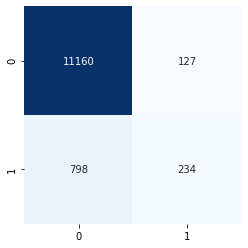

In [48]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

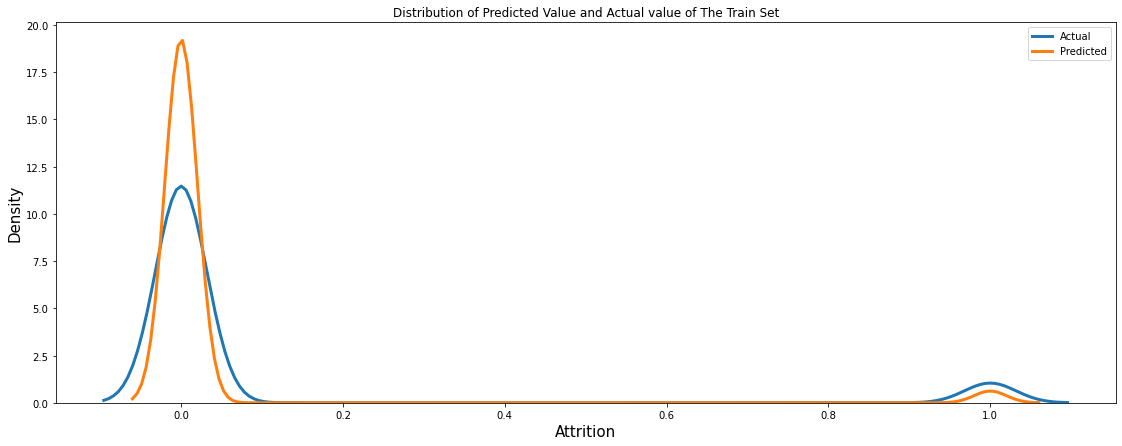

In [50]:
train_pred = logistic_regression.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

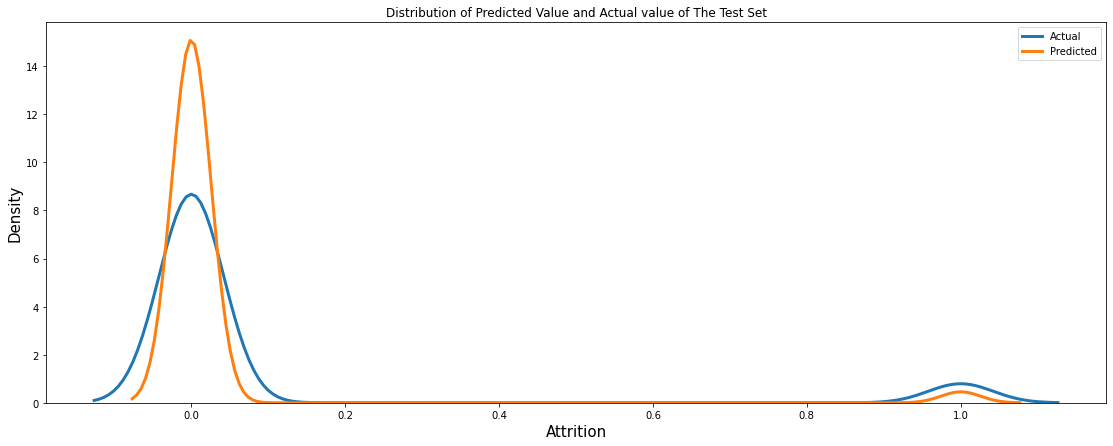

In [51]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

It is clear that this does not overfit since the 0 and 1 distribution are not close.

### Random Forest

In [52]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train , y_train)

accuracy_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_random_forest = pd.DataFrame({
    "Accuracy" : accuracy_rf, 
    "Precision": precision_rf,
    "Recall" : recall_rf, 
    "f1Score" : f1_rf,
    "ROCAUC" : roc_auc_rf
})

result_random_forest

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.925520   0.693548  0.200483  0.312673  0.875025
1  0.932420   0.717742  0.228093  0.346380  0.873875
2  0.928158   0.715867  0.231902  0.338235  0.863009
3  0.923592   0.753731  0.228409  0.342358  0.872970
4  0.926832   0.744000  0.220859  0.349057  0.866464

In [53]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     11287
           1       0.75      0.23      0.36      1032

    accuracy                           0.93     12319
   macro avg       0.84      0.61      0.66     12319
weighted avg       0.92      0.93      0.91     12319



<AxesSubplot:>

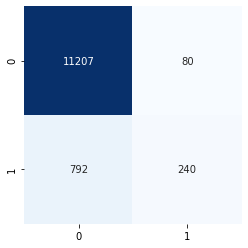

In [54]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

This result shows that the True Negatives are detected and predicted correctly. But, this may be show that the data is imbalanced.

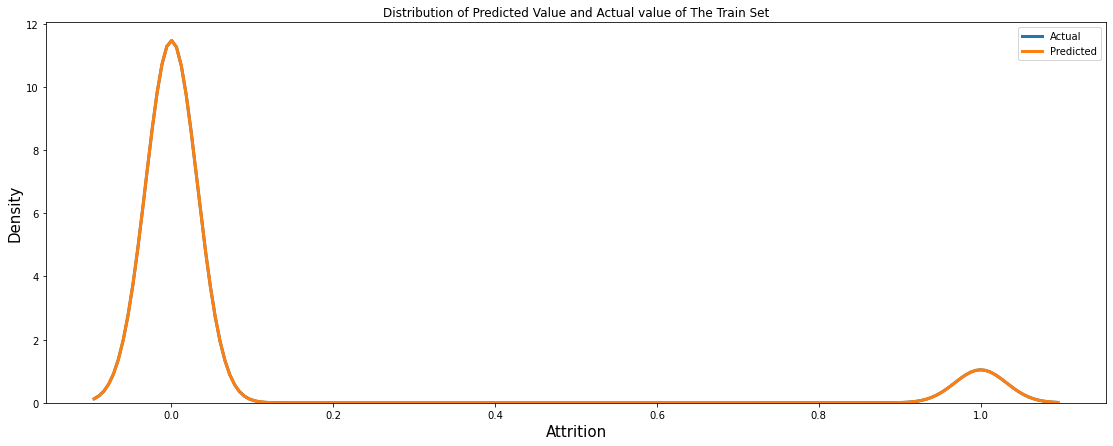

In [55]:
train_pred = random_forest.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

Random forest overfitted to the training data.

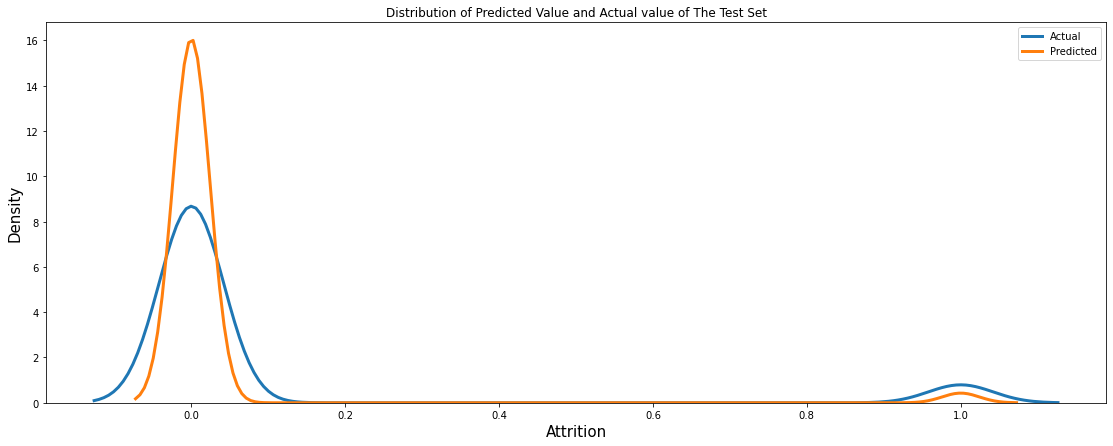

In [56]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### XGBoost

In [57]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

accuracy_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_xgb = pd.DataFrame({
    "Accuracy" : accuracy_xgb,
    "Precision": precision_xgb,
    "Recall" : recall_xgb, 
    "f1Score" : f1_xgb,
    "ROCAUC" : roc_auc_xgb
})

result_xgb

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.927245   0.639798  0.306763  0.414694  0.880619
1  0.930086   0.617251  0.295103  0.399303  0.876093
2  0.925419   0.600503  0.293252  0.394064  0.856685
3  0.921664   0.634328  0.289773  0.397816  0.873374
4  0.927542   0.623472  0.312883  0.416667  0.869601

In [58]:
y_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96     11287
           1       0.63      0.29      0.39      1032

    accuracy                           0.93     12319
   macro avg       0.78      0.64      0.68     12319
weighted avg       0.91      0.93      0.91     12319



<AxesSubplot:>

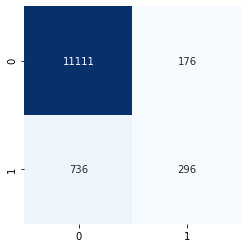

In [59]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

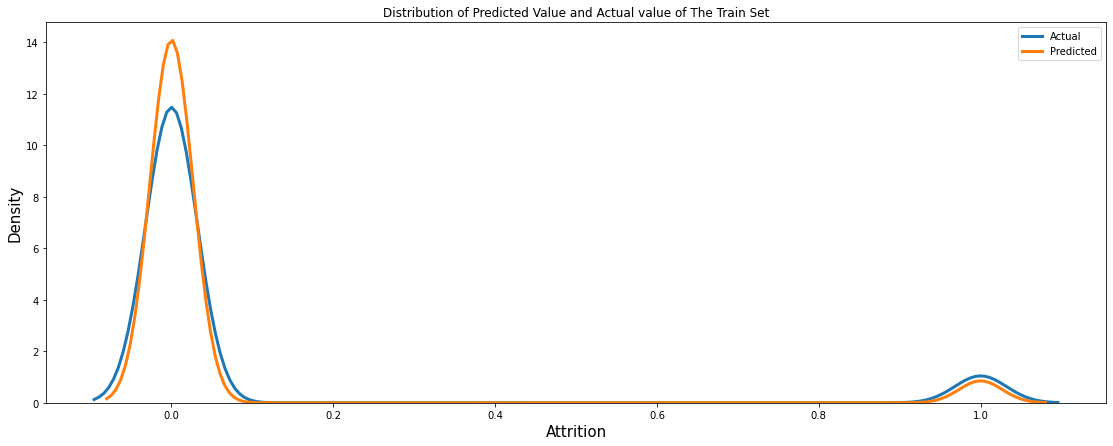

In [60]:
train_pred = xgboost.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

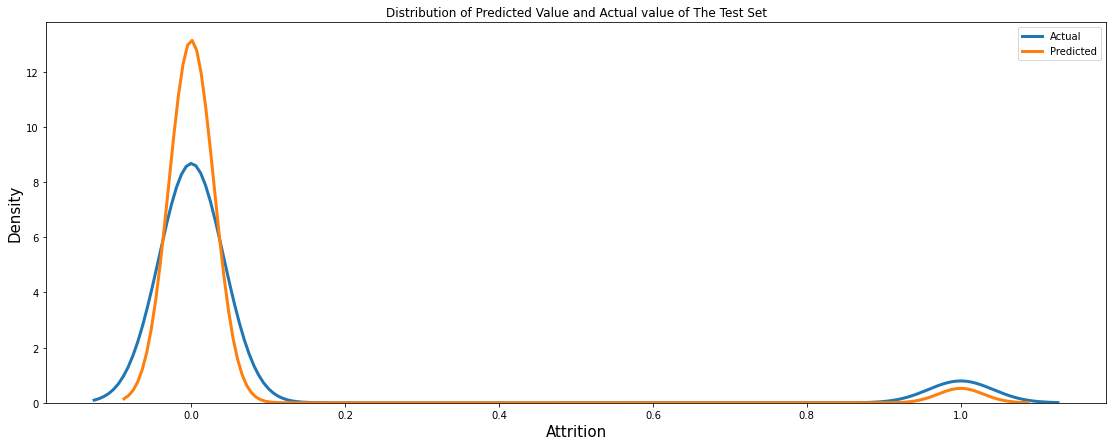

In [61]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Ada Boost

In [62]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

accuracy_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_ada = pd.DataFrame({
    "Accuracy" : accuracy_ada, 
    "Precision": precision_ada,
    "Recall" : recall_ada, 
    "f1Score" : f1_ada,
    "ROCAUC" : roc_auc_ada
})

result_ada

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.924505   0.617978  0.265700  0.371622  0.879903
1  0.928767   0.606322  0.271907  0.375445  0.875344
2  0.926941   0.625330  0.290798  0.396985  0.865584
3  0.923592   0.653753  0.306818  0.417633  0.877092
4  0.927339   0.633423  0.288344  0.396290  0.875469

In [64]:
y_pred = adaboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     11287
           1       0.65      0.30      0.41      1032

    accuracy                           0.93     12319
   macro avg       0.79      0.64      0.69     12319
weighted avg       0.91      0.93      0.92     12319



<AxesSubplot:>

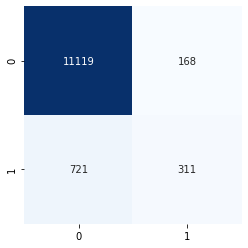

In [65]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

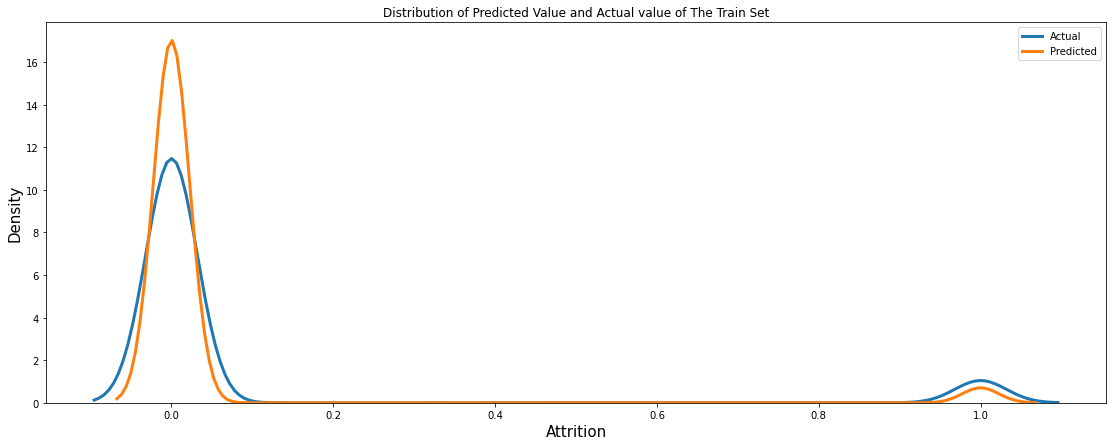

In [66]:
train_pred = adaboost.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

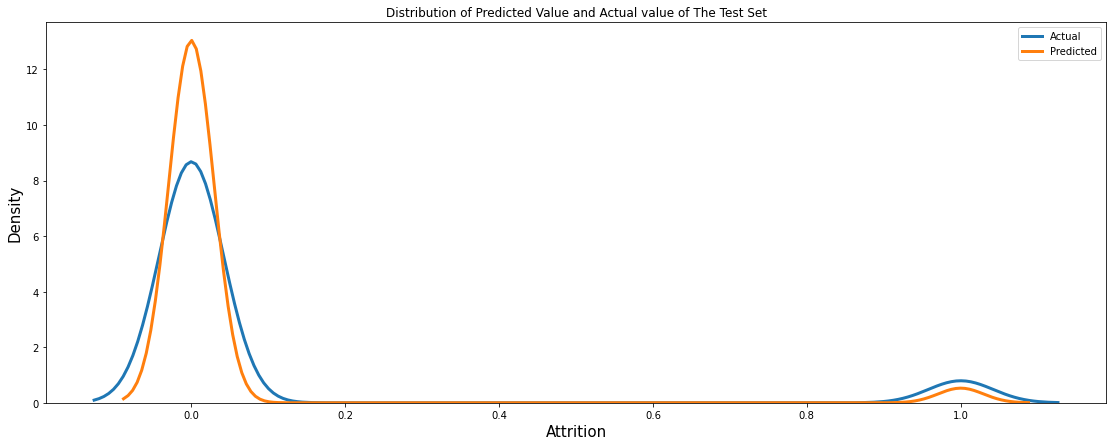

In [67]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Bagging Classifier

In [68]:
bagging = BaggingClassifier()
bagging.fit(X_train, y_train)

accuracy_bag = cross_val_score(bagging , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_bag = cross_val_score(bagging , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_bag = cross_val_score(bagging , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_bag = cross_val_score(bagging , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_bag = cross_val_score(bagging , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)
result_bag = pd.DataFrame({
    "Accuracy" : accuracy_bag, 
    "Precision": precision_bag,
    "Recall" : recall_bag, 
    "f1Score" : f1_bag,
    "ROCAUC" : roc_auc_bag
})

result_bag

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.921766   0.578035  0.223430  0.346056  0.815930
1  0.925317   0.588040  0.226804  0.331151  0.819529
2  0.924201   0.629310  0.253988  0.355401  0.811146
3  0.919432   0.608824  0.237500  0.337171  0.808835
4  0.923381   0.592025  0.219632  0.322351  0.808236

In [69]:
y_pred = bagging.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.99      0.96     11287
           1       0.63      0.25      0.36      1032

    accuracy                           0.92     12319
   macro avg       0.78      0.62      0.66     12319
weighted avg       0.91      0.92      0.91     12319



<AxesSubplot:>

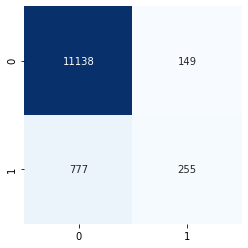

In [70]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

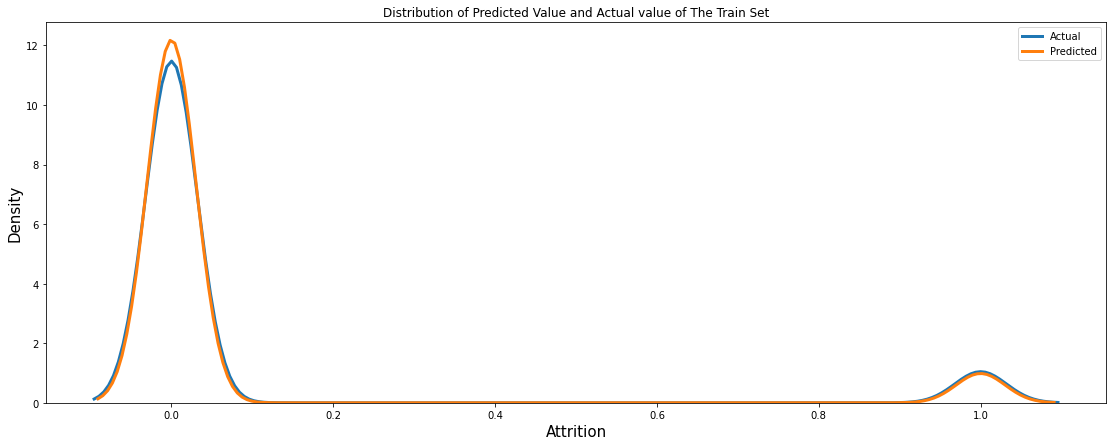

In [71]:
train_pred = bagging.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

Bagging algorithm has overfitted to the training data.

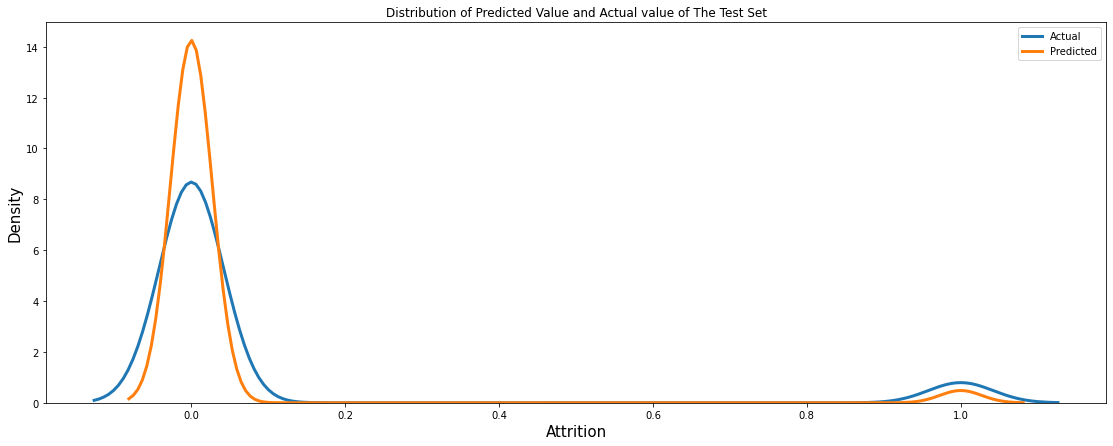

In [72]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Neural Network

In [83]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.00001)

nn = Sequential()
nn.add(tf.keras.Input(shape=(len(X_train.columns),)))
nn.add(Dense(20, activation='selu'))
nn.add(Dense(15, activation='selu'))
nn.add(Dense(1,activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = nn.fit(X_train, y_train, validation_split=0.25, epochs=10, verbose=0)
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_train, y_train, verbose=0) 

result_nn = pd.DataFrame(np.array([[loss, accuracy, precision, recall, f1_score]]), 
             columns=["Loss","Accuracy","Precision","Recall","f1-score"])

result_nn

Loss  Accuracy  Precision    Recall  f1-score
0  0.740122  0.561716   0.092403  0.445221  0.147029

In [84]:
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_test, y_test, verbose=0) 

result_nn = pd.DataFrame(np.array([[loss, accuracy, precision, recall, f1_score]]), 
             columns=["Loss","Accuracy","Precision","Recall","f1-score"])

result_nn

Loss  Accuracy  Precision    Recall  f1-score
0  0.741464  0.560516   0.088543  0.418692  0.140108

### LightGBM

In [85]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)

accuracy_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_lightgbm = pd.DataFrame({
    "Accuracy" : accuracy_lightgbm, 
    "Precision": precision_lightgbm,
    "Recall" : recall_lightgbm, 
    "f1Score" : f1_lightgbm,
    "ROCAUC" : roc_auc_lightgbm
})

result_lightgbm

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.927549   0.653226  0.293478  0.405000  0.885361
1  0.932522   0.665672  0.287371  0.401440  0.882333
2  0.929680   0.656410  0.314110  0.424896  0.870484
3  0.922983   0.657143  0.287500  0.400000  0.883477
4  0.927948   0.638522  0.296933  0.405360  0.878875

In [86]:
y_pred = lightgbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.96     11287
           1       0.70      0.30      0.42      1032

    accuracy                           0.93     12319
   macro avg       0.82      0.64      0.69     12319
weighted avg       0.92      0.93      0.92     12319



<AxesSubplot:>

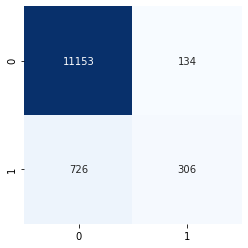

In [87]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

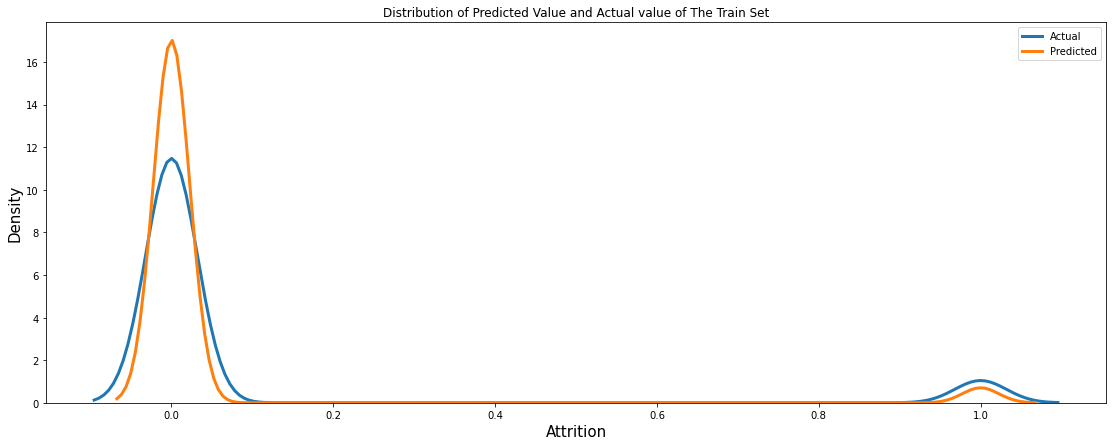

In [88]:
train_pred = lightgbm.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

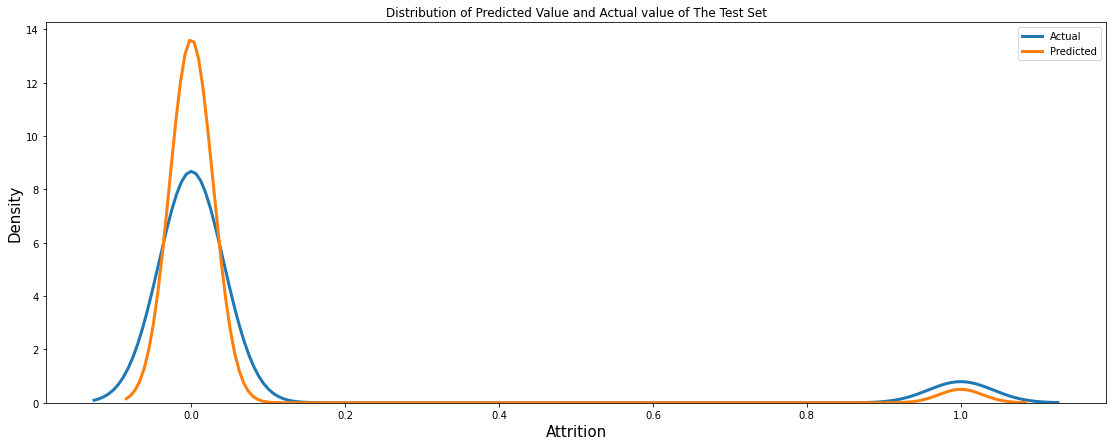

In [89]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

## Optimization

### Feature Selection

Reading the dataset again and dropping the unnecessary columns that were detected before. Also, an inspection is that the columns that include "noninvasive" are highly correlated with the same column that does not contain the same phrase. Therefore, it is decided that these columns will be dropped and the corresponding ones will be used.

In [90]:
dataset2 = pd.read_csv('dataset.csv')

In [91]:
dataset2.drop(["Unnamed: 83", "encounter_id", "patient_id"] , axis=1 , inplace=True)
dataset2 = dataset2.dropna()

In [92]:
categorical_dataset = dataset2.select_dtypes("object")
numerical_dataset = dataset2.select_dtypes(exclude=["object"])
for i in numerical_dataset.columns:
    if ("noninvasive" in i):
        numerical_dataset.drop([i], axis=1, inplace=True)


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [93]:
dataset2

hospital_id   age        bmi  elective_surgery        ethnicity gender  \
0              118  68.0  22.730000                 0        Caucasian      M   
1               81  77.0  27.420000                 0        Caucasian      F   
5               83  67.0  27.560000                 0        Caucasian      M   
10              77  72.0  28.257052                 1         Hispanic      F   
17             118  46.0  25.845717                 0         Hispanic      M   
...            ...   ...        ...               ...              ...    ...   
91698          195  47.0  51.439842                 1        Caucasian      M   
91706          121  54.0  19.770448                 0  Native American      M   
91708           30  75.0  23.060250                 0        Caucasian      M   
91709          121  56.0  47.179671                 0        Caucasian      F   
91712          104  82.0  22.031250                 1        Caucasian      F   

       height           icu_admit_source  icu_id icu_stay_type  ... cirrhosis  \
0       180.3                      Floor      92         admit  ...       0.0   
1       160.0                      Floor      90         admit  ...       0.0   
5       190.5       Accident & Emergency      95         admit  ...       0.0   
10      154.9  Operating Room / Recovery     113         admit  ...       0.0   
17      167.6       Accident & Emergency      92         admit  ...       0.0   
...       ...                        ...     ...           ...  ...       ...   
91698   195.0  Operating Room / Recovery     908         admit  ...       0.0   
91706   177.8       Accident & Emergency     925         admit  ...       0.0   
91708   177.8                      Floor     927         admit  ...       0.0   
91709   183.0                      Floor     925         admit  ...       0.0   
91712   160.0  Operating Room / Recovery     926         admit  ...       0.0   

       diabetes_mellitus  hepatic_failure  immunosuppression  leukemia  \
0                    1.0              0.0                0.0       0.0   
1                    1.0              0.0                0.0       0.0   
5                    1.0              0.0                0.0       0.0   
10                   0.0              0.0                1.0       0.0   
17                   0.0              0.0                0.0       0.0   
...                  ...              ...                ...       ...   
91698                0.0              0.0                0.0       0.0   
91706                0.0              0.0                0.0       0.0   
91708                1.0              0.0                0.0       0.0   
91709                0.0              0.0                0.0       0.0   
91712                0.0              0.0                0.0       0.0   

       lymphoma  solid_tumor_with_metastasis  apache_3j_bodysystem  \
0           0.0                          0.0                Sepsis   
1           0.0                          0.0           Respiratory   
5           0.0                          0.0          Neurological   
10          0.0                          0.0           Respiratory   
17          0.0                          0.0           Respiratory   
...         ...                          ...                   ...   
91698       0.0                          0.0      Gastrointestinal   
91706       0.0                          0.0        Cardiovascular   
91708       0.0                          1.0                Sepsis   
91709       0.0                          0.0                Sepsis   
91712       0.0                          0.0      Gastrointestinal   

       apache_2_bodysystem  hospital_death  
0           Cardiovascular               0  
1              Respiratory               0  
5               Neurologic               0  
10             Respiratory               0  
17             Respiratory               0  
...                    ...             ...  
91698     Gastro

When the data is examined, all int64 type of data are categorical data. So, we add these to our categorical data.

In [94]:
d = numerical_dataset.select_dtypes("int64")
categorical_dataset = categorical_dataset.join(d)

Still, there are some categorical data in the numeric data structure and we detect them by looking for 2 valued columns.

In [95]:
numerical_dataset = numerical_dataset.select_dtypes(exclude=["int64"])
c = []
for i in numerical_dataset.columns:
    if len(np.unique(dataset2[i])) <= 2:
        categorical_dataset = categorical_dataset.join(dataset2[i])
        numerical_dataset.drop([i],axis=1, inplace=True)

numerical_dataset

age        bmi  height  pre_icu_los_days  weight  apache_2_diagnosis  \
0      68.0  22.730000   180.3          0.541667    73.9               113.0   
1      77.0  27.420000   160.0          0.927778    70.2               108.0   
5      67.0  27.560000   190.5          0.000694   100.0               301.0   
10     72.0  28.257052   154.9          0.004861    67.8               303.0   
17     46.0  25.845717   167.6          0.000000    72.6               108.0   
...     ...        ...     ...               ...     ...                 ...   
91698  47.0  51.439842   195.0          0.033333   186.0               304.0   
91706  54.0  19.770448   177.8          0.025694    62.5               109.0   
91708  75.0  23.060250   177.8          0.298611    72.9               113.0   
91709  56.0  47.179671   183.0          0.120139   158.0               113.0   
91712  82.0  22.031250   160.0          0.018056    56.4               304.0   

       apache_3j_diagnosis  gcs_eyes_apache  gcs_motor_apache  \
0                   502.01              3.0               6.0   
1                   203.01              1.0               3.0   
5                   403.01              4.0               6.0   
10                 1304.08              4.0               6.0   
17                  203.01              1.0               4.0   
...                    ...              ...               ...   
91698              1406.01              4.0               6.0   
91706               108.01              4.0               6.0   
91708               501.06              4.0               6.0   
91709               501.05              4.0               6.0   
91712              1409.02              4.0               6.0   

       gcs_verbal_apache  ...  h1_spo2_max  h1_spo2_min  h1_sysbp_max  \
0                    4.0  ...        100.0         74.0         131.0   
1                    1.0  ...         95.0         70.0          95.0   
5                    5.0  ...         97.0         97.0         143.0   
10                   5.0  ...         99.0         93.0         145.0   
17                   1.0  ...         99.0         95.0         169.0   
...                  ...  ...          ...          ...           ...   
91698                2.0  ...         99.0         97.0         104.0   
91706                5.0  ...        100.0         98.0         169.0   
91708                5.0  ...         98.0         97.0          94.0   
91709                5.0  ...         99.0         96.0         127.0   
91712                1.0  ...        100.0        100.0          93.0   

       h1_sysbp_min  d1_glucose_max  d1_glucose_min  d1_potassium_max  \
0             115.0           168.0           109.0               4.0   
1              71.0           145.0           128.0               4.2   
5             143.0           156.0           125.0               3.9   
10            114.0           158.0           133.0               4.2   
17            115.0           143.0           143.0               4.9   
...             ...             ...             ...               ...   
91698         104.0           128.0           128.0               4.2   
91706         143.0            91.0            91.0               4.2   
91708          87.0           400.0           187.0               4.2   
91709         107.0           177.0           177.0               3.8   
91712          89.0           158.0           158.0               4.9   

       d1_potassium_min  apache_4a_hospital_death_prob  \
0                   3.4                           0.10   
1                   3.8                           0.47   
5                   3.7                           0.05   
10                  4.2                           0.01   
17                  4.9                           0.11   
...                 ...                            ...   
91698               4.2                           0.01   
91706               4.1                         

In [96]:
categorical_dataset

ethnicity gender           icu_admit_source icu_stay_type  \
0            Caucasian      M                      Floor         admit   
1            Caucasian      F                      Floor         admit   
5            Caucasian      M       Accident & Emergency         admit   
10            Hispanic      F  Operating Room / Recovery         admit   
17            Hispanic      M       Accident & Emergency         admit   
...                ...    ...                        ...           ...   
91698        Caucasian      M  Operating Room / Recovery         admit   
91706  Native American      M       Accident & Emergency         admit   
91708        Caucasian      M                      Floor         admit   
91709        Caucasian      F                      Floor         admit   
91712        Caucasian      F  Operating Room / Recovery         admit   

           icu_type apache_3j_bodysystem apache_2_bodysystem  hospital_id  \
0             CTICU               Sepsis      Cardiovascular          118   
1      Med-Surg ICU          Respiratory         Respiratory           81   
5      Med-Surg ICU         Neurological          Neurologic           83   
10     Med-Surg ICU          Respiratory         Respiratory           77   
17            CTICU          Respiratory         Respiratory          118   
...             ...                  ...                 ...          ...   
91698  Med-Surg ICU     Gastrointestinal    Gastrointestinal          195   
91706  Med-Surg ICU       Cardiovascular      Cardiovascular          121   
91708   Cardiac ICU               Sepsis      Cardiovascular           30   
91709  Med-Surg ICU               Sepsis      Cardiovascular          121   
91712  Med-Surg ICU     Gastrointestinal    Gastrointestinal          104   

       elective_surgery  icu_id  ...  intubated_apache  ventilated_apache  \
0                     0      92  ...               0.0                0.0   
1                     0      90  ...               0.0                1.0   
5                     0      95  ...               0.0                0.0   
10                    1     113  ...               0.0                0.0   
17                    0      92  ...               1.0                1.0   
...                 ...     ...  ...               ...                ...   
91698                 1     908  ...               0.0                0.0   
91706                 0     925  ...               0.0                0.0   
91708                 0     927  ...               0.0                1.0   
91709                 0     925  ...               0.0                0.0   
91712                 1     926  ...               0.0                1.0   

       aids  cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
0       0.0        0.0                1.0              0.0                0.0   
1       0.0        0.0                1.0              0.0                0.0   
5       0.0        0.0                1.0              0.0                0.0   
10      0.0        0.0                0.0              0.0                1.0   
17      0.0        0.0                0.0              0.0                0.0   
...     ...        ...                ...              ...                ...   
91698   0.0        0.0                0.0              0.0                0.0   
91706   0.0        0.0                0.0              0.0                0.0   
91708   0.0        0.0                1.0              0.0                0.0   
91709   0.0        0.0                0.0              0.0                0.0   
91712   0.0        0.0                0.0              0.0                0.0   

       leukemia  lymphoma  solid_tumor_with_metastasis  
0           0.0       0.0                          0.0  
1           0.0       0.0                          0.0  
5           0.0       0.0                          0.0  
10          0.0       0.0                          0.0  
17          0.0 

In [97]:
chis = []
y = dataset2["hospital_death"]
for i in numerical_dataset.columns:
    x = dataset2[i]
    chi2, p = chisquare([x, y])
    chis.append((i,chi2))

invalid value encountered in divide
divide by zero encountered in divide


In [98]:
chis_means = []
for i in chis:
    chis_means.append((i[0], np.mean(i[1])))
chis_means

[('age', 62.3337040967859),
 ('bmi', 29.043322174473158),
 ('height', 169.53990747655644),
 ('pre_icu_los_days', nan),
 ('weight', 84.19358493420137),
 ('apache_2_diagnosis', 181.74926621823786),
 ('apache_3j_diagnosis', 546.9811300171339),
 ('gcs_eyes_apache', 3.280788033137203),
 ('gcs_motor_apache', 5.272297314815976),
 ('gcs_verbal_apache', 3.795477884136881),
 ('heart_rate_apache', 100.7372252022161),
 ('map_apache', 88.07686033807825),
 ('resprate_apache', 25.87810687202985),
 ('temp_apache', 36.167918751574604),
 ('d1_diasbp_max', 89.4256850290398),
 ('d1_diasbp_min', 49.35320126046898),
 ('d1_heartrate_max', 103.8576569531905),
 ('d1_heartrate_min', nan),
 ('d1_mbp_max', 105.09484644108954),
 ('d1_mbp_min', 63.91134475904319),
 ('d1_resprate_max', 28.847139789210694),
 ('d1_resprate_min', nan),
 ('d1_spo2_max', 99.06040566287571),
 ('d1_spo2_min', nan),
 ('d1_sysbp_max', 148.82146784331462),
 ('d1_sysbp_min', 95.62788345281015),
 ('d1_temp_max', 37.06107288871958),
 ('d1_temp_m

In [99]:
selected_numericals = numerical_dataset.copy()
for i in chis_means:
    if (i[1] > 110):
        selected_numericals.drop([i[0]], axis=1, inplace=True)
        
selected_numericals

age        bmi  pre_icu_los_days  weight  gcs_eyes_apache  \
0      68.0  22.730000          0.541667    73.9              3.0   
1      77.0  27.420000          0.927778    70.2              1.0   
5      67.0  27.560000          0.000694   100.0              4.0   
10     72.0  28.257052          0.004861    67.8              4.0   
17     46.0  25.845717          0.000000    72.6              1.0   
...     ...        ...               ...     ...              ...   
91698  47.0  51.439842          0.033333   186.0              4.0   
91706  54.0  19.770448          0.025694    62.5              4.0   
91708  75.0  23.060250          0.298611    72.9              4.0   
91709  56.0  47.179671          0.120139   158.0              4.0   
91712  82.0  22.031250          0.018056    56.4              4.0   

       gcs_motor_apache  gcs_verbal_apache  heart_rate_apache  map_apache  \
0                   6.0                4.0              118.0        40.0   
1                   3.0                1.0              120.0        46.0   
5                   6.0                5.0              113.0       130.0   
10                  6.0                5.0              101.0        72.0   
17                  4.0                1.0              114.0       113.0   
...                 ...                ...                ...         ...   
91698               6.0                2.0              137.0        66.0   
91706               6.0                5.0               55.0        62.0   
91708               6.0                5.0              115.0        48.0   
91709               6.0                5.0              100.0        62.0   
91712               6.0                1.0              101.0        56.0   

       resprate_apache  ...  h1_mbp_max  h1_mbp_min  h1_resprate_max  \
0                 36.0  ...        86.0        85.0             26.0   
1                 33.0  ...        85.0        57.0             31.0   
5                 35.0  ...       111.0       111.0             12.0   
10                15.0  ...        91.0        87.0             23.0   
17                34.0  ...       104.0        88.0             21.0   
...                ...  ...         ...         ...              ...   
91698              8.0  ...        78.0        78.0             15.0   
91706             12.0  ...       111.0       108.0             19.0   
91708              9.0  ...        64.0        55.0             24.0   
91709             33.0  ...        78.0        68.0             28.0   
91712              4.0  ...        56.0        56.0             19.0   

       h1_resprate_min  h1_spo2_max  h1_spo2_min  d1_potassium_max  \
0                 18.0        100.0         74.0               4.0   
1                 28.0         95.0         70.0               4.2   
5                 12.0         97.0         97.0               3.9   
10                14.0         99.0         93.0               4.2   
17                 9.0         99.0         95.0               4.9   
...                ...          ...          ...               ...   
91698              9.0         99.0         97.0               4.2   
91706             13.0        100.0         98.0               4.2   
91708             16.0         98.0         97.0               4.2   
91709             22.0         99.0         96.0               3.8   
91712              9.0        100.0        100.0               4.9   

       d1_potassium_min  apache_4a_hospital_death_prob  \
0                   3.4                           0.10   
1                   3.8                           0.47   
5                   3.7                           0.05   
10                  4.2                           0.01   
17                  4.9                           0.11   
...                 ...                            ...   
91698               4.2                           0.01   
91706               4.1                           0.01   
91708               4.2   

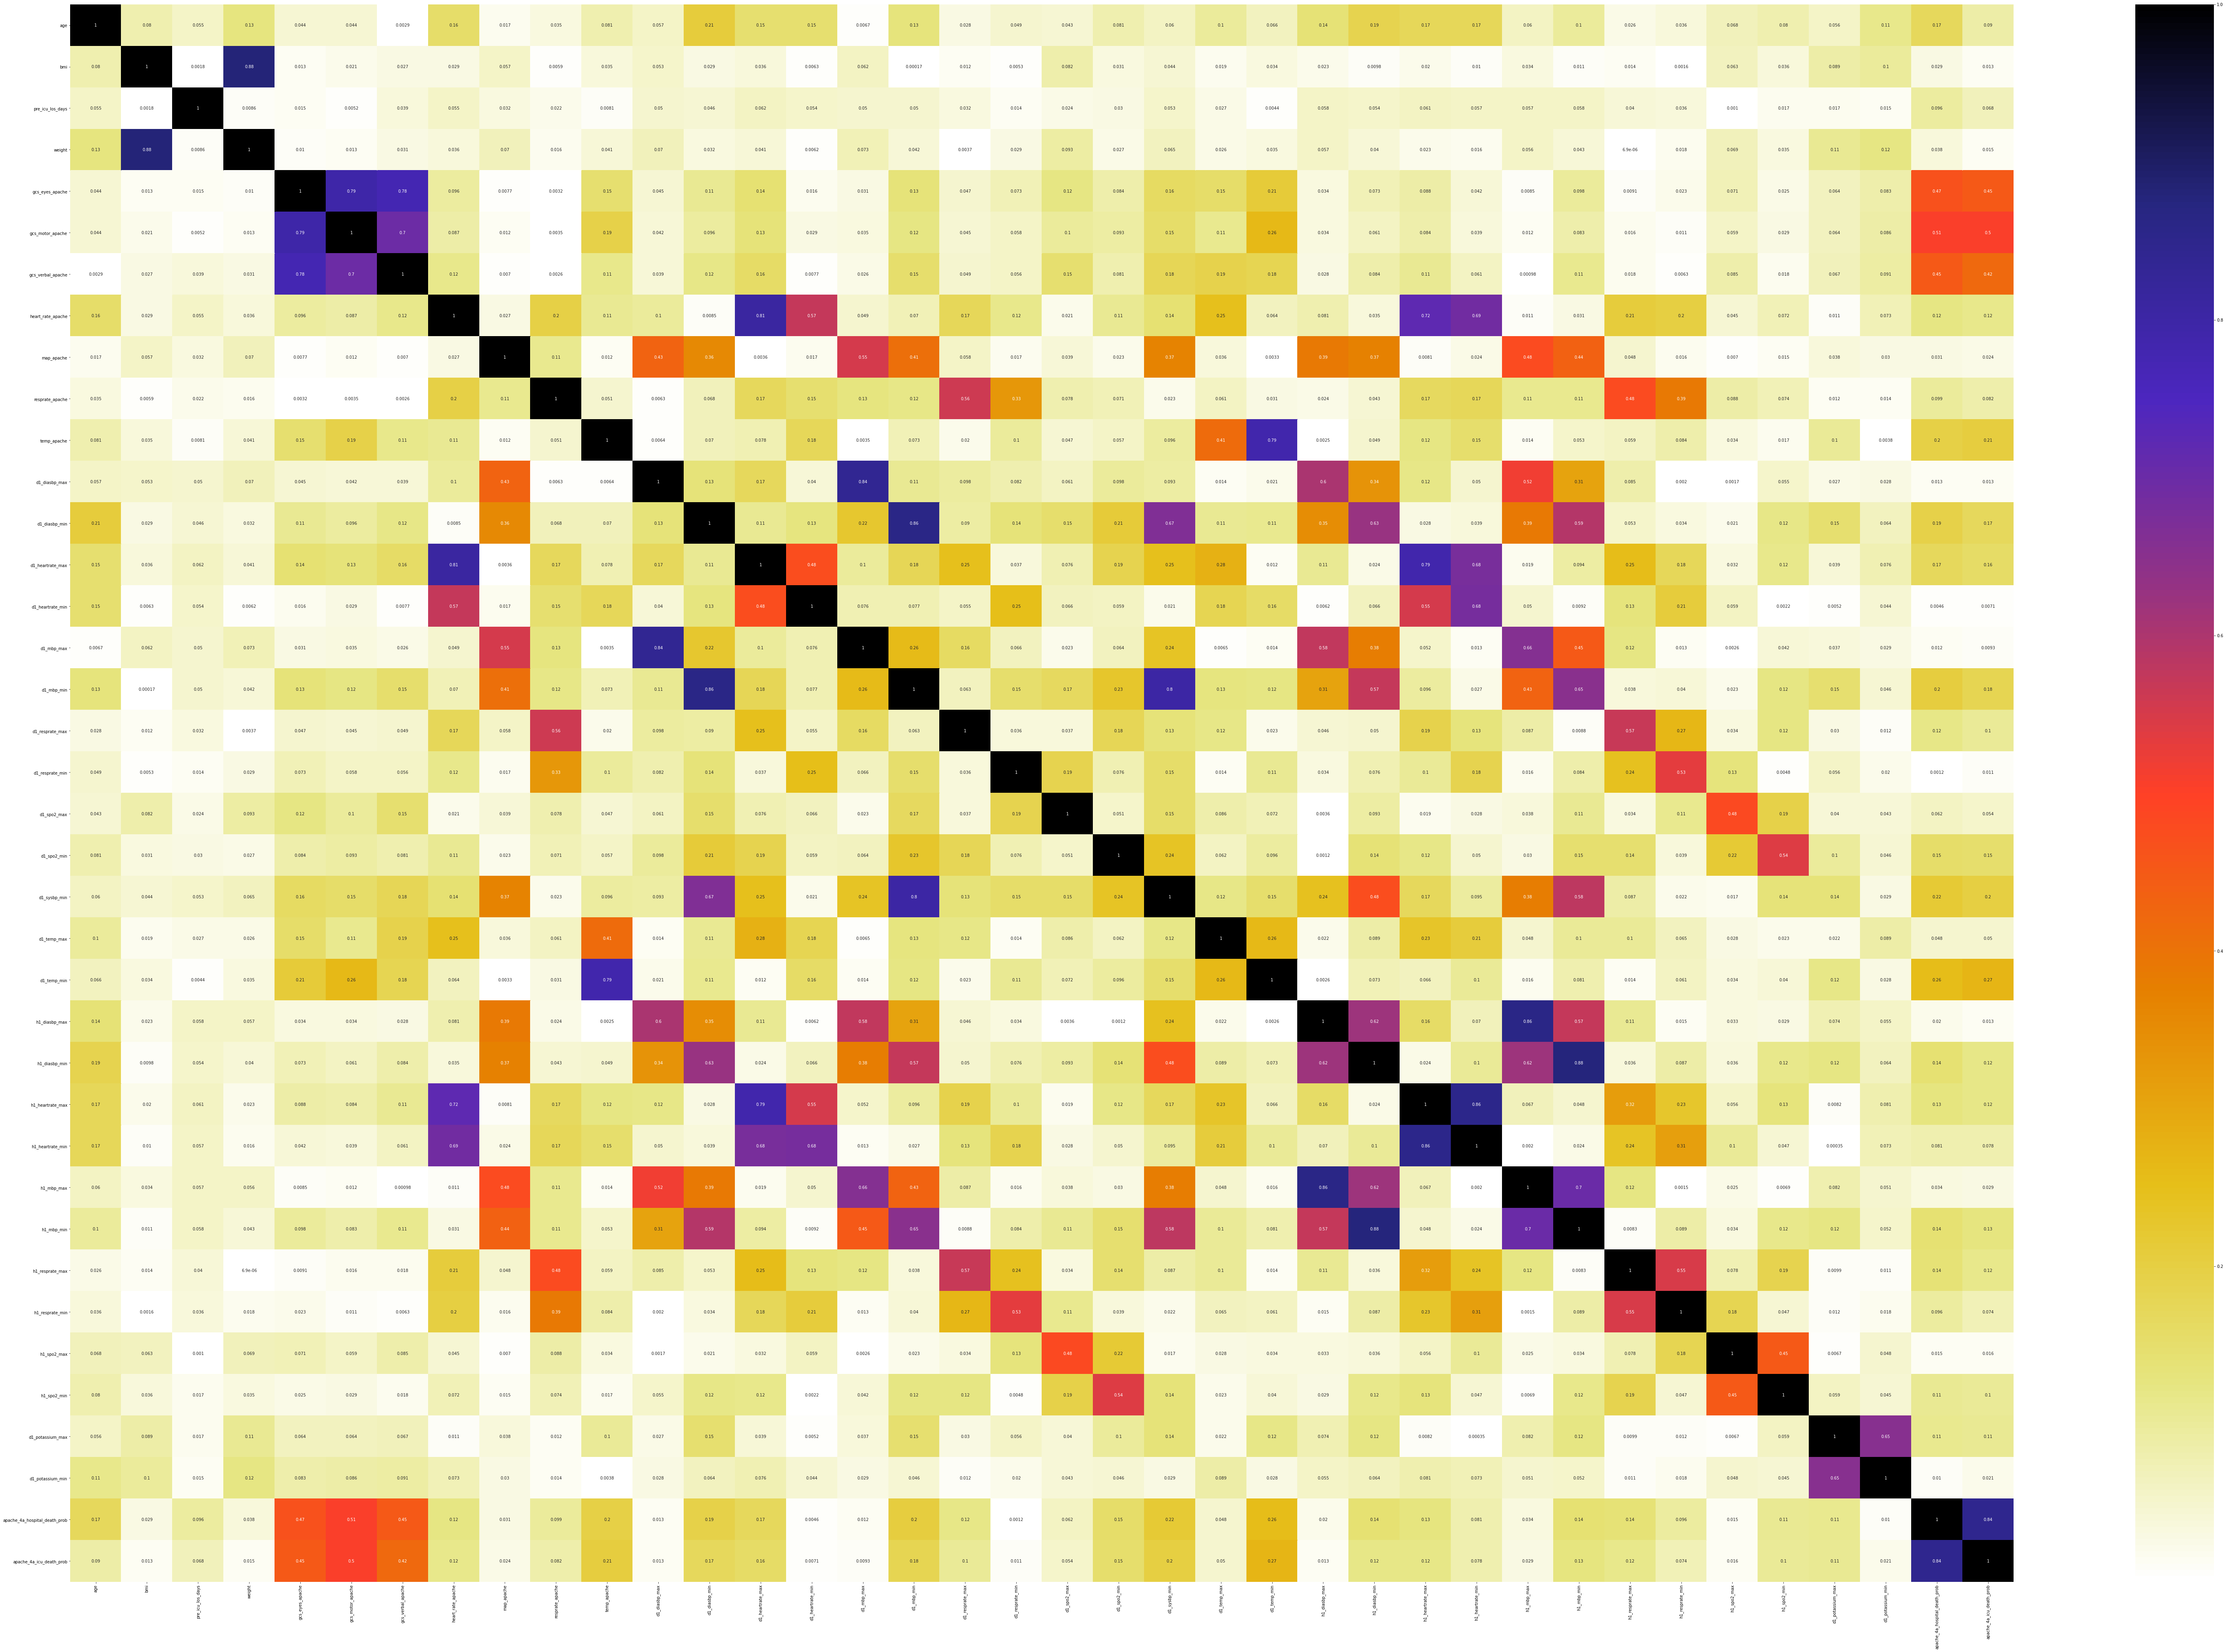

In [100]:
pearson_corr = selected_numericals.corr().abs()
plt.figure(figsize=(108,72))
sns.heatmap(pearson_corr , cmap=plt.cm.CMRmap_r , annot=True)
plt.show()

In [101]:
upper = pearson_corr.where(np.triu(np.ones(pearson_corr.shape), k=1).astype(np.bool))
to_be_combined = [column for column in upper.columns if any(upper[column] >= 0.70) and any(upper[column] < 1)]
to_be_combined

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


['weight',
 'gcs_motor_apache',
 'gcs_verbal_apache',
 'd1_heartrate_max',
 'd1_mbp_max',
 'd1_mbp_min',
 'd1_sysbp_min',
 'd1_temp_min',
 'h1_heartrate_max',
 'h1_heartrate_min',
 'h1_mbp_max',
 'h1_mbp_min',
 'apache_4a_icu_death_prob']

In [102]:
def combine(column1, column2, data, target):
    f1 = data[column1]
    f2 = data[column2]
    weights = np.arange(0,1.1,0.1)
    
    combinations = []
    chi_vals = []
    for w in weights:
        f_combined = []
        for i in range(selected_numericals.shape[0]):
            f_combined.append(f1.iloc[i]*w + f2.iloc[i]*(1-w))
            
        chi2, p = chisquare([f_combined, target])
        chi_vals.append(np.mean(chi2))
        combinations.append(f_combined)
        
    min_index = np.argmin(chi_vals)
    return combinations[min_index]

In [103]:
temperature = combine("d1_temp_min", "temp_apache", selected_numericals, dataset2["hospital_death"])
heartrate = combine("h1_heartrate_max", "heart_rate_apache", selected_numericals, dataset2["hospital_death"])
mbp_diasbp_max = combine("h1_mbp_max", "h1_diasbp_max", selected_numericals, dataset2["hospital_death"])
mbp_diasbp_min = combine("h1_mbp_min", "h1_diasbp_min", selected_numericals, dataset2["hospital_death"])

In [104]:
selected_numericals = selected_numericals.drop(["d1_temp_min", "temp_apache", "h1_heartrate_max", "heart_rate_apache", 
                                                "h1_mbp_max", "h1_diasbp_max", "h1_mbp_min", "h1_diasbp_min"] ,axis=1)
selected_numericals.insert(selected_numericals.shape[1], "temperature", temperature)
selected_numericals.insert(selected_numericals.shape[1], "heartrate", heartrate)
selected_numericals.insert(selected_numericals.shape[1], "mbp_diasbp_max", mbp_diasbp_max)
selected_numericals.insert(selected_numericals.shape[1], "mbp_diasbp_min", mbp_diasbp_min)

In [105]:
selected_numericals

age        bmi  pre_icu_los_days  weight  gcs_eyes_apache  \
0      68.0  22.730000          0.541667    73.9              3.0   
1      77.0  27.420000          0.927778    70.2              1.0   
5      67.0  27.560000          0.000694   100.0              4.0   
10     72.0  28.257052          0.004861    67.8              4.0   
17     46.0  25.845717          0.000000    72.6              1.0   
...     ...        ...               ...     ...              ...   
91698  47.0  51.439842          0.033333   186.0              4.0   
91706  54.0  19.770448          0.025694    62.5              4.0   
91708  75.0  23.060250          0.298611    72.9              4.0   
91709  56.0  47.179671          0.120139   158.0              4.0   
91712  82.0  22.031250          0.018056    56.4              4.0   

       gcs_motor_apache  gcs_verbal_apache  map_apache  resprate_apache  \
0                   6.0                4.0        40.0             36.0   
1                   3.0                1.0        46.0             33.0   
5                   6.0                5.0       130.0             35.0   
10                  6.0                5.0        72.0             15.0   
17                  4.0                1.0       113.0             34.0   
...                 ...                ...         ...              ...   
91698               6.0                2.0        66.0              8.0   
91706               6.0                5.0        62.0             12.0   
91708               6.0                5.0        48.0              9.0   
91709               6.0                5.0        62.0             33.0   
91712               6.0                1.0        56.0              4.0   

       d1_diasbp_max  ...  h1_spo2_max  h1_spo2_min  d1_potassium_max  \
0               68.0  ...        100.0         74.0               4.0   
1               95.0  ...         95.0         70.0               4.2   
5              100.0  ...         97.0         97.0               3.9   
10              72.0  ...         99.0         93.0               4.2   
17              89.0  ...         99.0         95.0               4.9   
...              ...  ...          ...          ...               ...   
91698           83.0  ...         99.0         97.0               4.2   
91706          102.0  ...        100.0         98.0               4.2   
91708          104.0  ...         98.0         97.0               4.2   
91709           73.0  ...         99.0         96.0               3.8   
91712           47.0  ...        100.0        100.0               4.9   

       d1_potassium_min  apache_4a_hospital_death_prob  \
0                   3.4                           0.10   
1                   3.8                           0.47   
5                   3.7                           0.05   
10                  4.2                           0.01   
17                  4.9                           0.11   
...                 ...                            ...   
91698               4.2                           0.01   
91706               4.1                           0.01   
91708               4.2                           0.12   
91709               3.8                           0.03   
91712               4.9                           0.19   

       apache_4a_icu_death_prob  temperature  heartrate  mbp_diasbp_max  \
0                          0.05         37.2      119.0            68.0   
1                          0.29         35.1      114.0            61.0   
5                          0.02         36.6       83.0            89.0   
10                         0.00         36.7       90.0            72.0   
17                         0.06         36.4       94.0            89.0   
...                         ...          ...        ...             ...   
91698                      0.00         36.5      100.0            70.0   
91706                      0.00         36.6       59.0           102.0   
91708                      0.

In [106]:
categorical_features = categorical_dataset.columns
label_encoder = preprocessing.LabelEncoder()
for i in range(len(categorical_features)):
    categorical_dataset[categorical_features[i]] = label_encoder.fit_transform(categorical_dataset[categorical_features[i]].astype(str))
categorical_dataset

ethnicity  gender  icu_admit_source  icu_stay_type  icu_type  \
0              2       1                 1              0         2   
1              2       0                 1              0         5   
5              2       1                 0              0         5   
10             3       0                 2              0         5   
17             3       1                 0              0         2   
...          ...     ...               ...            ...       ...   
91698          2       1                 2              0         5   
91706          4       1                 0              0         5   
91708          2       1                 1              0         3   
91709          2       0                 1              0         5   
91712          2       0                 2              0         5   

       apache_3j_bodysystem  apache_2_bodysystem  hospital_id  \
0                         9                    0           13   
1                         8                    6          120   
5                         7                    4          121   
10                        8                    6          115   
17                        8                    6           13   
...                     ...                  ...          ...   
91698                     1                    1           67   
91706                     0                    0           15   
91708                     9                    0           81   
91709                     9                    0           15   
91712                     1                    1            5   

       elective_surgery  icu_id  ...  intubated_apache  ventilated_apache  \
0                     0     203  ...                 0                  0   
1                     0     193  ...                 0                  1   
5                     0     210  ...                 0                  0   
10                    1       5  ...                 0                  0   
17                    0     203  ...                 1                  1   
...                 ...     ...  ...               ...                ...   
91698                 1     198  ...                 0                  0   
91706                 0     206  ...                 0                  0   
91708                 0     208  ...                 0                  1   
91709                 0     206  ...                 0                  0   
91712                 1     207  ...                 0                  1   

       aids  cirrhosis  diabetes_mellitus  hepatic_failure  immunosuppression  \
0         0          0                  1                0                  0   
1         0          0                  1                0                  0   
5         0          0                  1                0                  0   
10        0          0                  0                0                  1   
17        0          0                  0                0                  0   
...     ...        ...                ...              ...                ...   
91698     0          0                  0                0                  0   
91706     0          0                  0                0                  0   
91708     0          0                  1                0                  0   
91709     0          0                  0                0                  0   
91712     0          0                  0                0                  0   

       leukemia  lymphoma  solid_tumor_with_metastasis  
0             0         0                            0  
1             0         0                            0  
5             0         0                            0  
10            0         0                            0  
17            0         0                            0  
...         ...       ...                          ...  
91698         0         0                            0  
91706         0    

In [107]:
def polychoric_correlation(x, y):
    x = np.asarray(x)
    y = np.asarray(y)
    n = len(x)

    table = np.zeros((2, 2))
    for i in range(n):
        if x[i] == 1:
            if y[i] == 1:
                table[0, 0] += 1
            else:
                table[0, 1] += 1
        else:
            if y[i] == 1:
                table[1, 0] += 1
            else:
                table[1, 1] += 1

    numerator = table[0, 0] * table[1, 1] - table[0, 1] * table[1, 0]
    denominator = np.sqrt((table[0, 0] + table[0, 1]) *
                        (table[0, 0] + table[1, 0]) *
                        (table[1, 1] + table[0, 1]) *
                        (table[1, 1] + table[1, 0]))
    return numerator / denominator

invalid value encountered in double_scalars


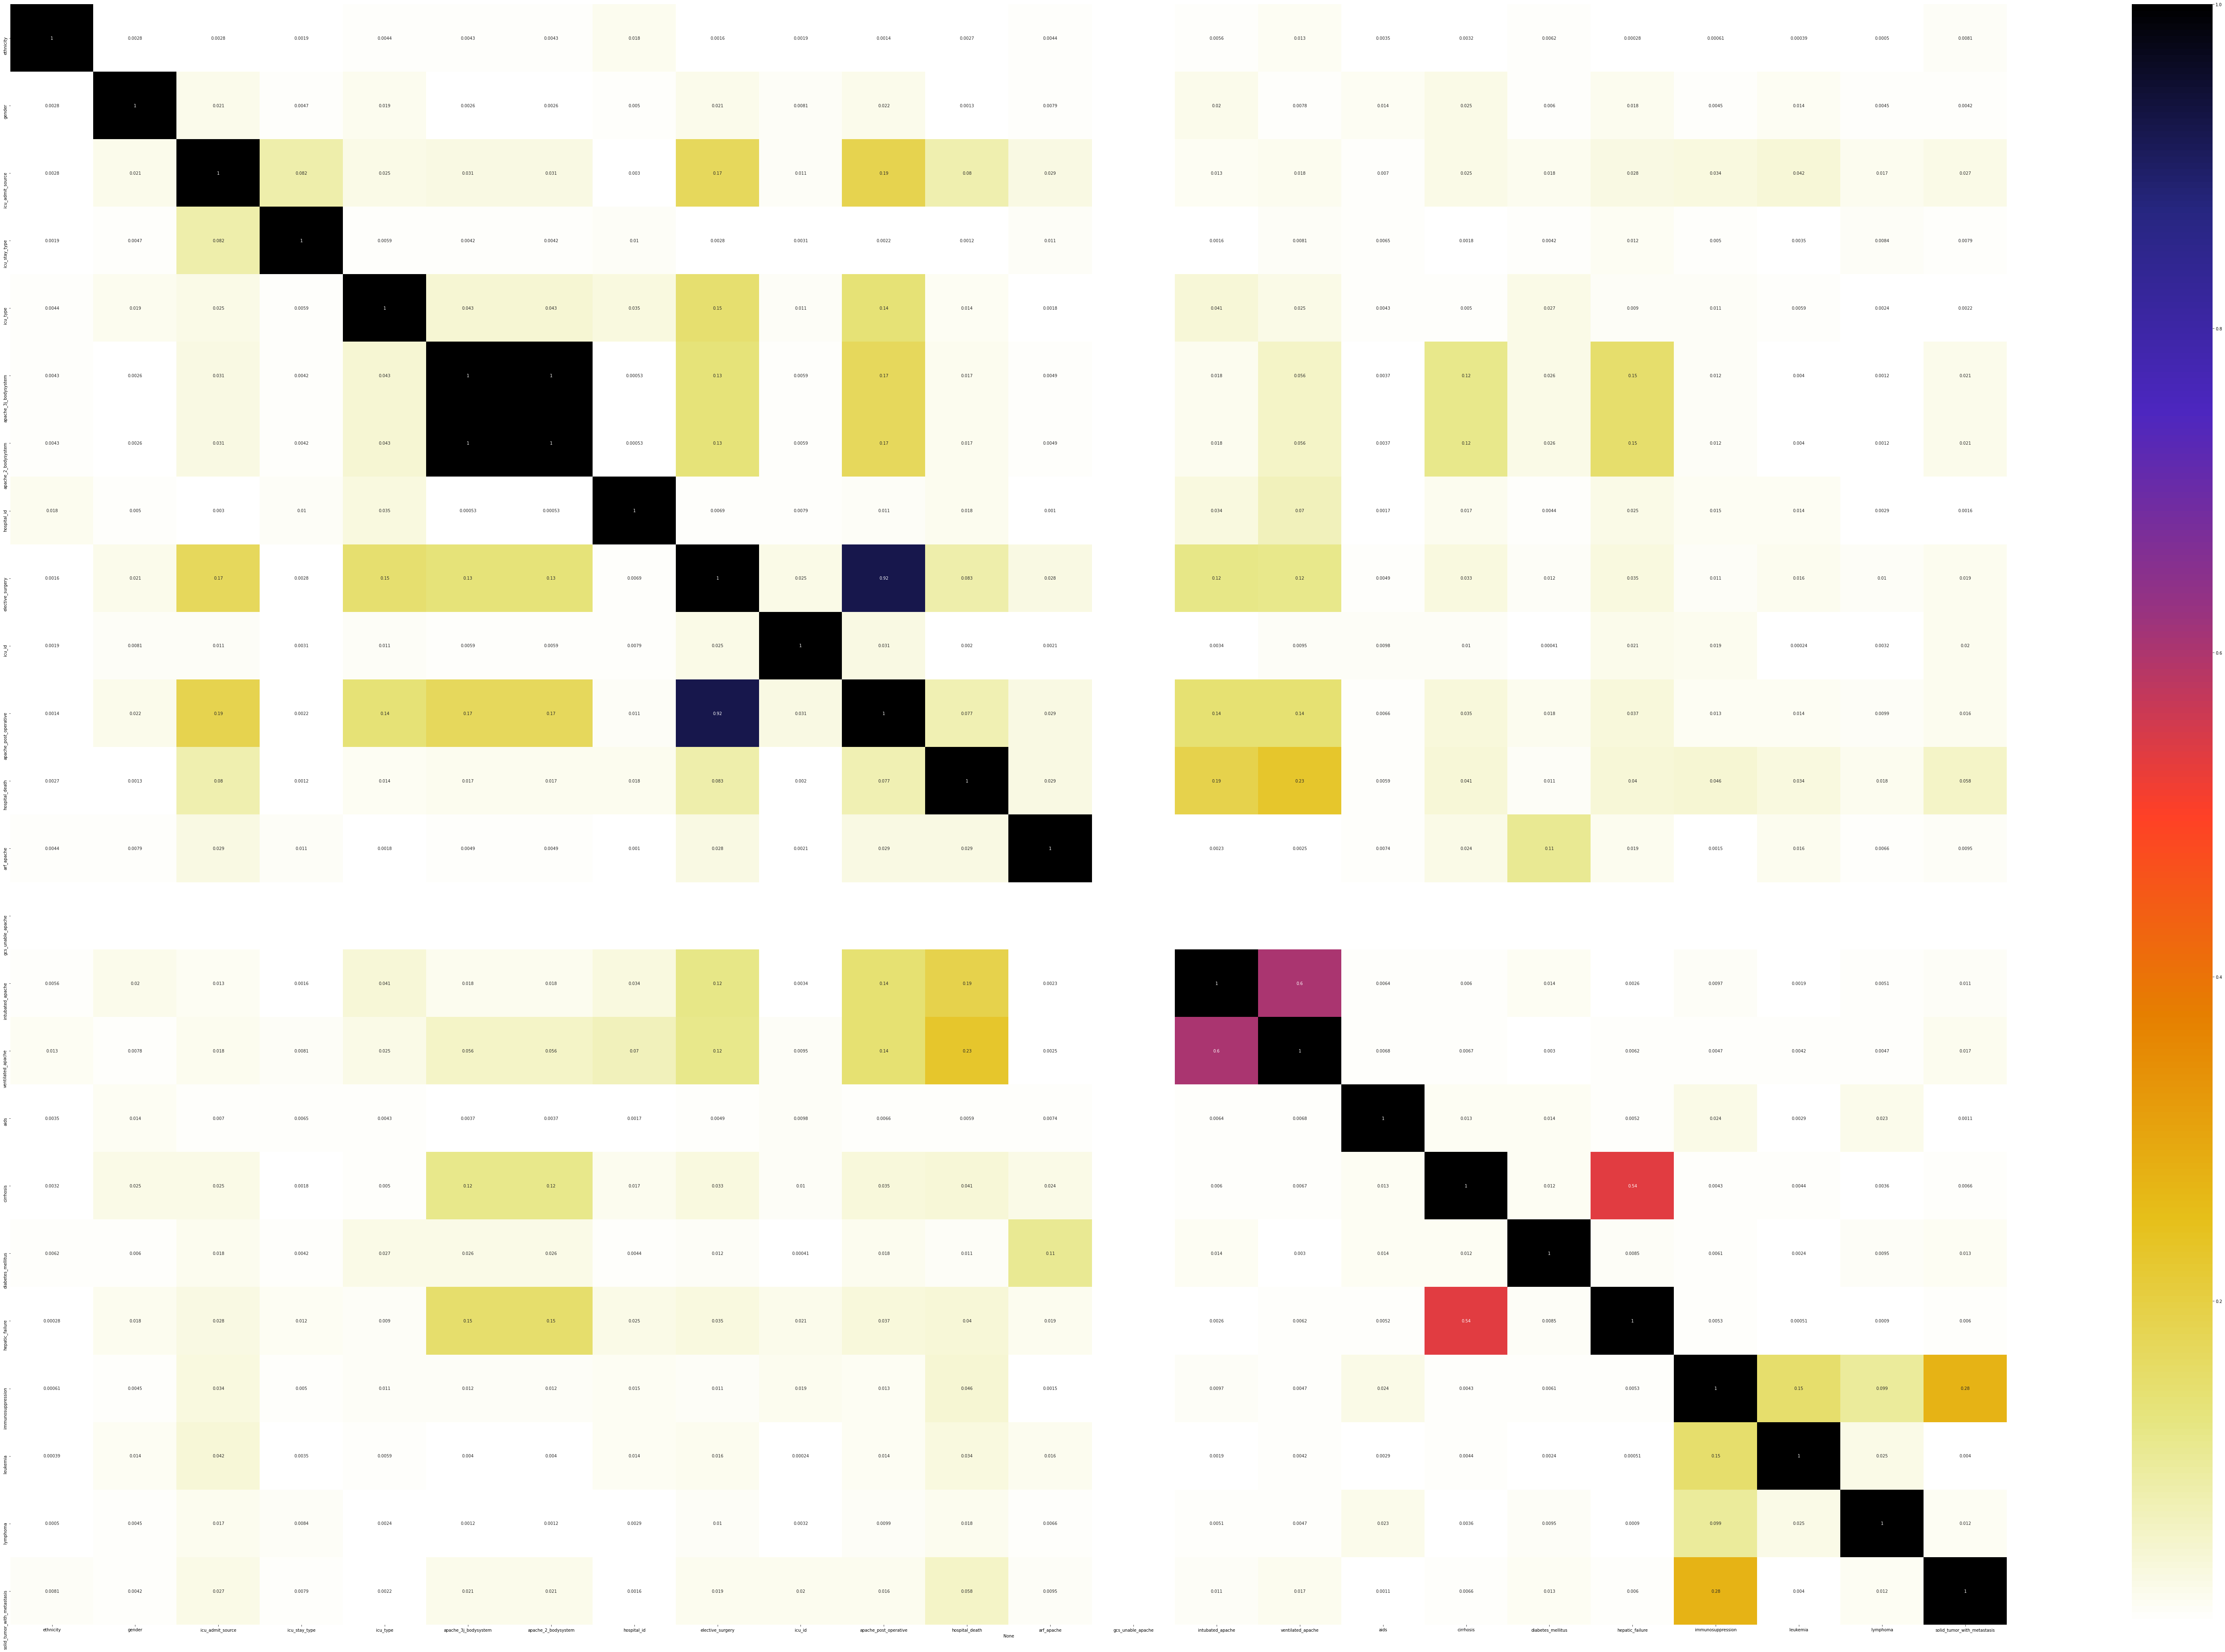

In [108]:
poly_corr = np.zeros((len(categorical_features),len(categorical_features)))
for i in range(len(categorical_features)):
    for j in range(len(categorical_features)):
        poly_corr[i][j] = polychoric_correlation(categorical_dataset[categorical_features[i]], categorical_dataset[categorical_features[j]])

poly_corr = np.abs(poly_corr)
poly_corr = pd.DataFrame(poly_corr, columns=[categorical_features])
poly_corr = poly_corr.set_index(categorical_features)
plt.figure(figsize=(108,72))
sns.heatmap(np.abs(poly_corr) , cmap=plt.cm.CMRmap_r , annot=True)
plt.show()

In [109]:
categorical_dataset.drop(["apache_3j_bodysystem"], axis=1, inplace=True)#apache_2_bodysystem
categorical_dataset.drop(["apache_post_operative"], axis=1, inplace=True)#elective_surgery

In [110]:
correlations = []
for i in categorical_dataset.columns:
    if polychoric_correlation(categorical_dataset[i], dataset2["hospital_death"]) < 0.01:
        categorical_dataset.drop([i], axis=1, inplace=True)
categorical_dataset

invalid value encountered in double_scalars


icu_admit_source  hospital_id  hospital_death  arf_apache  \
0                     1           13               0           0   
1                     1          120               0           0   
5                     0          121               0           0   
10                    2          115               0           0   
17                    0           13               0           0   
...                 ...          ...             ...         ...   
91698                 2           67               0           0   
91706                 0           15               0           0   
91708                 1           81               0           0   
91709                 1           15               0           0   
91712                 2            5               0           0   

       gcs_unable_apache  intubated_apache  ventilated_apache  cirrhosis  \
0                      0                 0                  0          0   
1                      0                 0                  1          0   
5                      0                 0                  0          0   
10                     0                 0                  0          0   
17                     0                 1                  1          0   
...                  ...               ...                ...        ...   
91698                  0                 0                  0          0   
91706                  0                 0                  0          0   
91708                  0                 0                  1          0   
91709                  0                 0                  0          0   
91712                  0                 0                  1          0   

       hepatic_failure  immunosuppression  leukemia  lymphoma  \
0                    0                  0         0         0   
1                    0                  0         0         0   
5                    0                  0         0         0   
10                   0                  1         0         0   
17                   0                  0         0         0   
...                ...                ...       ...       ...   
91698                0                  0         0         0   
91706                0                  0         0         0   
91708                0                  0         0         0   
91709                0                  0         0         0   
91712                0                  0         0         0   

       solid_tumor_with_metastasis  
0                                0  
1                                0  
5                                0  
10                               0  
17                               0  
...                            ...  
91698                            0  
91706                            0  
91708                            1  
91709                            0  
91712                            0  

[56935 rows x 13 columns]

In [111]:
dataset2 = selected_numericals.join(categorical_dataset)
dataset2

age        bmi  pre_icu_los_days  weight  gcs_eyes_apache  \
0      68.0  22.730000          0.541667    73.9              3.0   
1      77.0  27.420000          0.927778    70.2              1.0   
5      67.0  27.560000          0.000694   100.0              4.0   
10     72.0  28.257052          0.004861    67.8              4.0   
17     46.0  25.845717          0.000000    72.6              1.0   
...     ...        ...               ...     ...              ...   
91698  47.0  51.439842          0.033333   186.0              4.0   
91706  54.0  19.770448          0.025694    62.5              4.0   
91708  75.0  23.060250          0.298611    72.9              4.0   
91709  56.0  47.179671          0.120139   158.0              4.0   
91712  82.0  22.031250          0.018056    56.4              4.0   

       gcs_motor_apache  gcs_verbal_apache  map_apache  resprate_apache  \
0                   6.0                4.0        40.0             36.0   
1                   3.0                1.0        46.0             33.0   
5                   6.0                5.0       130.0             35.0   
10                  6.0                5.0        72.0             15.0   
17                  4.0                1.0       113.0             34.0   
...                 ...                ...         ...              ...   
91698               6.0                2.0        66.0              8.0   
91706               6.0                5.0        62.0             12.0   
91708               6.0                5.0        48.0              9.0   
91709               6.0                5.0        62.0             33.0   
91712               6.0                1.0        56.0              4.0   

       d1_diasbp_max  ...  arf_apache  gcs_unable_apache  intubated_apache  \
0               68.0  ...           0                  0                 0   
1               95.0  ...           0                  0                 0   
5              100.0  ...           0                  0                 0   
10              72.0  ...           0                  0                 0   
17              89.0  ...           0                  0                 1   
...              ...  ...         ...                ...               ...   
91698           83.0  ...           0                  0                 0   
91706          102.0  ...           0                  0                 0   
91708          104.0  ...           0                  0                 0   
91709           73.0  ...           0                  0                 0   
91712           47.0  ...           0                  0                 0   

       ventilated_apache  cirrhosis  hepatic_failure  immunosuppression  \
0                      0          0                0                  0   
1                      1          0                0                  0   
5                      0          0                0                  0   
10                     0          0                0                  1   
17                     1          0                0                  0   
...                  ...        ...              ...                ...   
91698                  0          0                0                  0   
91706                  0          0                0                  0   
91708                  1          0                0                  0   
91709                  0          0                0                  0   
91712                  1          0                0                  0   

       leukemia  lymphoma  solid_tumor_with_metastasis  
0             0         0                            0  
1             0         0                            0  
5             0         0                            0  
10            0         0                            0  
17            0         0                            0  
...         ...       ...                          ...  
91698         0         0                

## Downsample

0    52044
1     4891
Name: hospital_death, dtype: int64


<AxesSubplot:ylabel='Type'>

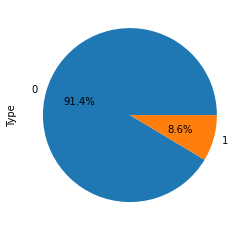

In [112]:
print(dataset2["hospital_death"].value_counts())

dataset2.groupby("hospital_death").size().plot(kind='pie',
                                       y = "hospital_death",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [113]:
death = dataset2[dataset2["hospital_death"] == 1]
survival  = dataset2[dataset2["hospital_death"] == 0]
death.shape, survival.shape

((4891, 47), (52044, 47))

In [114]:
survival_downsample = resample(survival,
             replace=True,
             n_samples=len(death),
             random_state=42)

print(survival_downsample.shape)

(4891, 47)


In [115]:
survival_downsample = resample(survival,
             replace=True,
             n_samples=len(death)*2,#######################
             random_state=42)

print(survival_downsample.shape)

(9782, 47)


0    9782
1    4891
Name: hospital_death, dtype: int64


<AxesSubplot:ylabel='Type'>

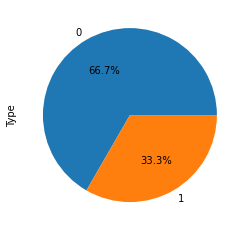

In [116]:
data_downsampled = pd.concat([survival_downsample, death])

print(data_downsampled["hospital_death"].value_counts())

data_downsampled.groupby('hospital_death').size().plot(kind='pie',
                                       y = "hospital_death",
                                       label = "Type",
                                       autopct='%1.1f%%')

In [119]:
X_train, X_test, y_train, y_test = get_train_test(data_downsampled)

In [120]:
cross_validation = KFold(n_splits=5 , shuffle=True , random_state=12345)

### Models

### Logistic Regression

In [121]:
logistic_regression = LogisticRegression(dual=False , random_state = 12345, max_iter=1000)
logistic_regression.fit(X_train , y_train)

accuracy_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lr = cross_val_score(logistic_regression , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_logistic_reg = pd.DataFrame({
    "Accuracy" : accuracy_lr, 
    "Precision": precision_lr,
    "Recall" : recall_lr, 
    "f1Score" : f1_lr,
    "ROCAUC" : roc_auc_lr
})

result_logistic_reg

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.804089   0.746457  0.613195  0.673295  0.864595
1  0.808348   0.765924  0.613520  0.681303  0.863666
2  0.788756   0.727273  0.570687  0.639535  0.846276
3  0.790797   0.735849  0.560052  0.636027  0.853257
4  0.786962   0.756058  0.572827  0.651811  0.846952

In [122]:
y_pred = logistic_regression.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1955
           1       0.77      0.61      0.68       980

    accuracy                           0.81      2935
   macro avg       0.80      0.76      0.77      2935
weighted avg       0.80      0.81      0.80      2935



<AxesSubplot:>

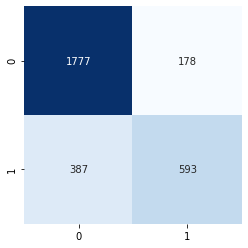

In [123]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

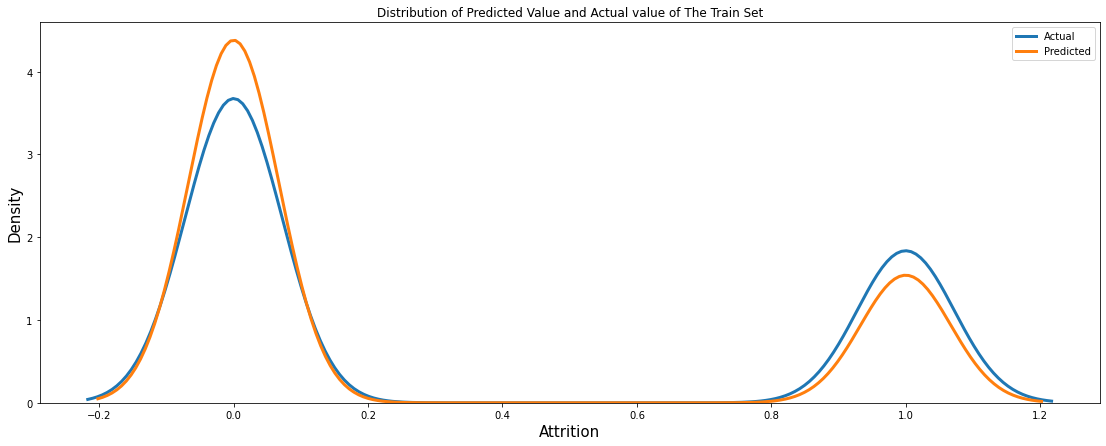

In [124]:
train_pred = logistic_regression.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

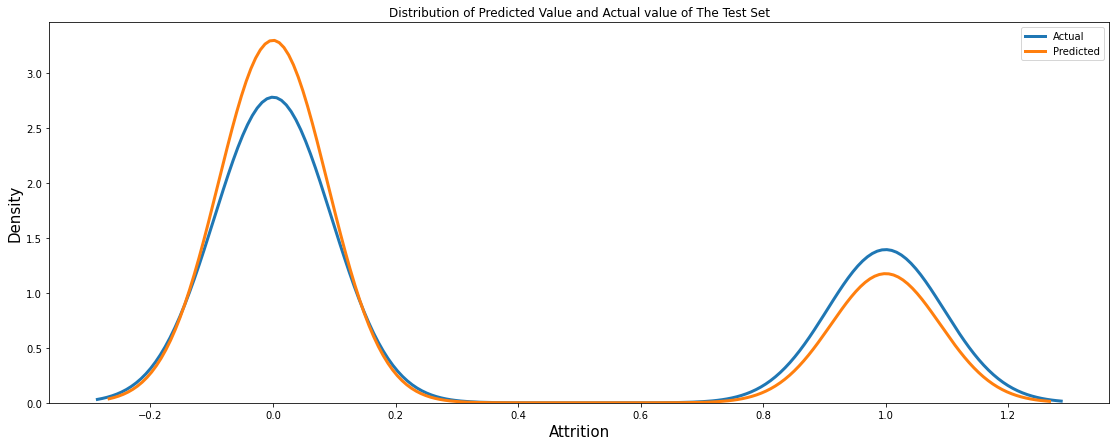

In [125]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### XGBoost Classifier

In [126]:
xgboost = XGBClassifier()
xgboost.fit(X_train, y_train)

accuracy_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_xgb = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_xgb = pd.DataFrame({
    "Accuracy" : accuracy_xgb,
    "Precision": precision_xgb,
    "Recall" : recall_xgb, 
    "f1Score" : f1_xgb,
    "ROCAUC" : roc_auc_xgb
})

result_xgb

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.821124   0.744799  0.694696  0.718876  0.881208
1  0.814310   0.742340  0.679847  0.709720  0.877611
2  0.804940   0.713506  0.678340  0.695479  0.870027
3  0.810822   0.731988  0.663185  0.695890  0.869897
4  0.797614   0.738827  0.647491  0.690150  0.863513

In [127]:
y_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1955
           1       0.75      0.68      0.71       980

    accuracy                           0.82      2935
   macro avg       0.80      0.78      0.79      2935
weighted avg       0.81      0.82      0.81      2935



<AxesSubplot:>

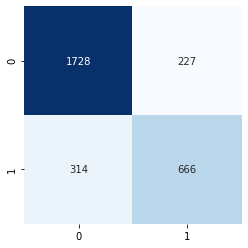

In [128]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

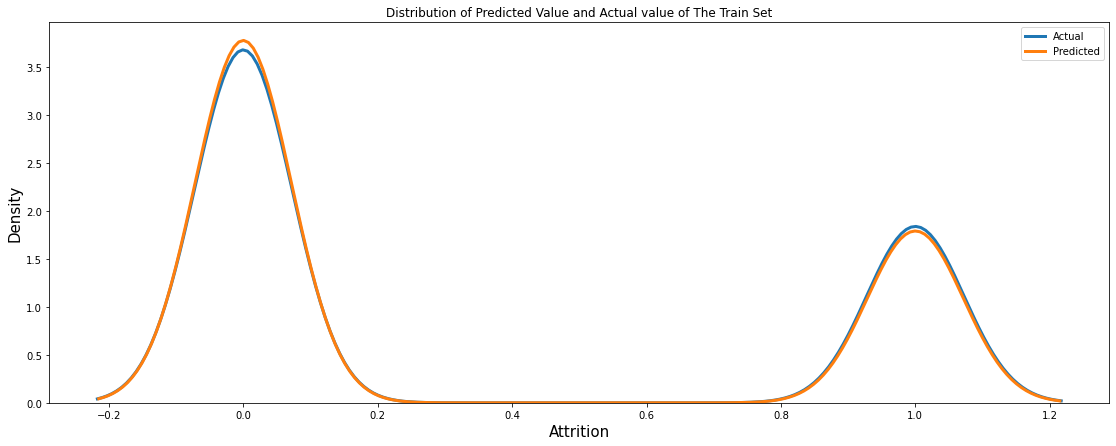

In [129]:
train_pred = xgboost.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

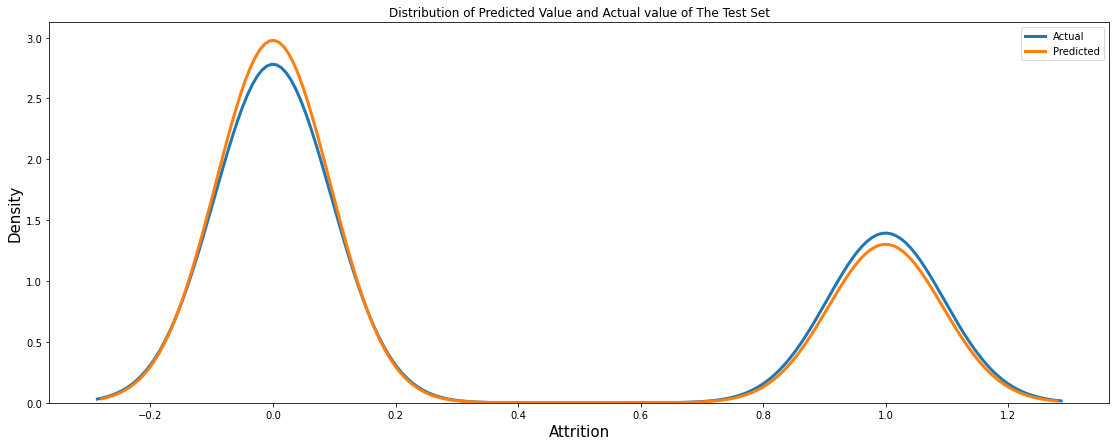

In [130]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Random Forest

In [131]:
random_forest = RandomForestClassifier()
random_forest.fit(X_train , y_train)

accuracy_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_random_forest = pd.DataFrame({
    "Accuracy" : accuracy_rf, 
    "Precision": precision_rf,
    "Recall" : recall_rf, 
    "f1Score" : f1_rf,
    "ROCAUC" : roc_auc_rf
})

result_random_forest

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.825809   0.765306  0.672704  0.713393  0.890143
1  0.819847   0.767103  0.668367  0.720488  0.894676
2  0.816865   0.745214  0.660182  0.695291  0.881847
3  0.812953   0.749609  0.630548  0.679487  0.873479
4  0.809970   0.768546  0.634027  0.695007  0.878558

In [132]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.91      0.88      1955
           1       0.80      0.67      0.73       980

    accuracy                           0.83      2935
   macro avg       0.82      0.79      0.80      2935
weighted avg       0.83      0.83      0.83      2935



<AxesSubplot:>

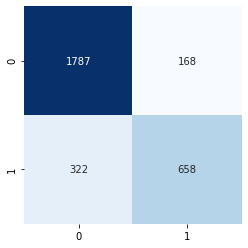

In [133]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

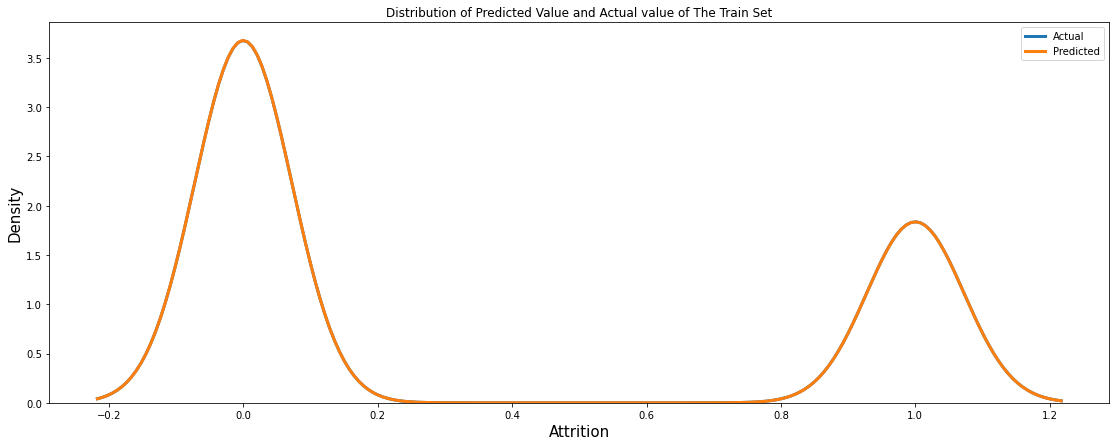

In [134]:
train_pred = random_forest.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

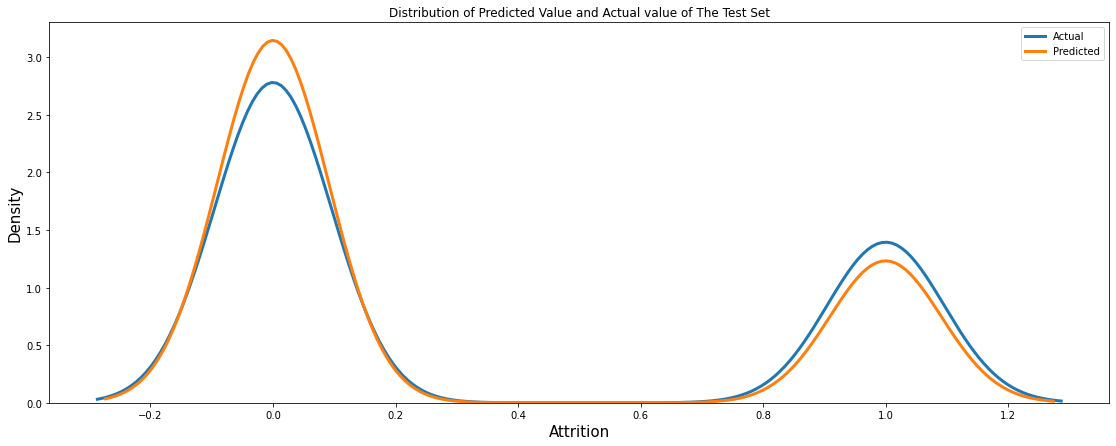

In [135]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Adaboost Classifier

In [136]:
adaboost = AdaBoostClassifier()
adaboost.fit(X_train, y_train)

accuracy_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_ada = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_ada = pd.DataFrame({
    "Accuracy" : accuracy_ada, 
    "Precision": precision_ada,
    "Recall" : recall_ada, 
    "f1Score" : f1_ada,
    "ROCAUC" : roc_auc_ada
})

result_ada

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.809625   0.728933  0.671410  0.698990  0.879624
1  0.816014   0.754335  0.665816  0.707317  0.883535
2  0.801533   0.733538  0.621271  0.672753  0.862835
3  0.798040   0.721884  0.620104  0.667135  0.869662
4  0.801023   0.752161  0.638923  0.690933  0.863853

In [137]:
y_pred = adaboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.89      0.86      1955
           1       0.75      0.65      0.70       980

    accuracy                           0.81      2935
   macro avg       0.79      0.77      0.78      2935
weighted avg       0.81      0.81      0.81      2935



<AxesSubplot:>

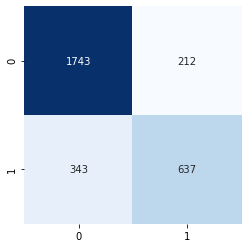

In [138]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

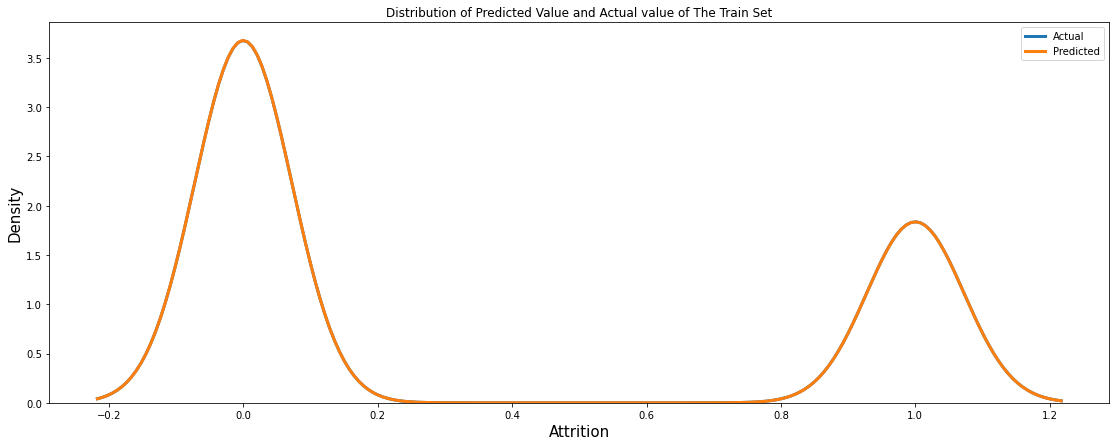

In [139]:
train_pred = random_forest.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

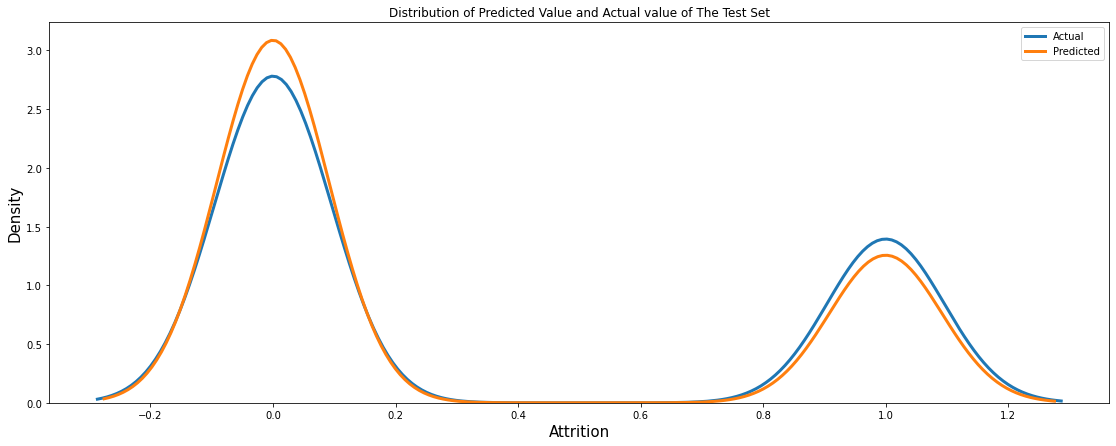

In [140]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Neural Network

In [141]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

opt = tf.keras.optimizers.SGD(learning_rate=0.00001)

nn = Sequential()
nn.add(tf.keras.Input(shape=(len(X_train.columns),)))
nn.add(Dense(5, activation='relu'))
nn.add(Dense(21, activation='relu'))
nn.add(Dense(1,activation='sigmoid'))

nn.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy', f1_m, precision_m, recall_m])
history = nn.fit(X_train, y_train, validation_split=0.25, epochs=10, verbose=0)
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_train, y_train, verbose=0) 

result_nn = pd.DataFrame(np.array([[loss, accuracy, precision, recall, f1_score]]), 
             columns=["Loss","Accuracy","Precision","Recall","f1-score"])

result_nn

Loss  Accuracy  Precision    Recall  f1-score
0  0.713804  0.433464   0.334845  0.711982  0.447104

In [183]:
loss, accuracy, f1_score, precision, recall = nn.evaluate(X_test, y_test, verbose=0) 

result_nn = pd.DataFrame(np.array([[loss, accuracy, precision, recall, f1_score]]), 
             columns=["Loss","Accuracy","Precision","Recall","f1-score"])

result_nn

Loss  Accuracy  Precision    Recall  f1-score
0  0.716555  0.435094   0.335744  0.717682  0.449333

### LightGBM Classifier

In [143]:
lightgbm = LGBMClassifier()
lightgbm.fit(X_train, y_train)

accuracy_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lightgbm = cross_val_score(lightgbm , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_lightgbm = pd.DataFrame({
    "Accuracy" : accuracy_lightgbm, 
    "Precision": precision_lightgbm,
    "Recall" : recall_lightgbm, 
    "f1Score" : f1_lightgbm,
    "ROCAUC" : roc_auc_lightgbm
})

result_lightgbm

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.819421   0.748930  0.679172  0.712347  0.885137
1  0.826235   0.764789  0.692602  0.726908  0.890319
2  0.808348   0.730935  0.658885  0.693042  0.877212
3  0.809544   0.739850  0.642298  0.687631  0.874046
4  0.812527   0.760000  0.674419  0.714656  0.874972

In [144]:
y_pred = lightgbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1955
           1       0.75      0.69      0.72       980

    accuracy                           0.82      2935
   macro avg       0.80      0.79      0.79      2935
weighted avg       0.82      0.82      0.82      2935



<AxesSubplot:>

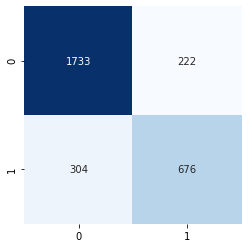

In [145]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

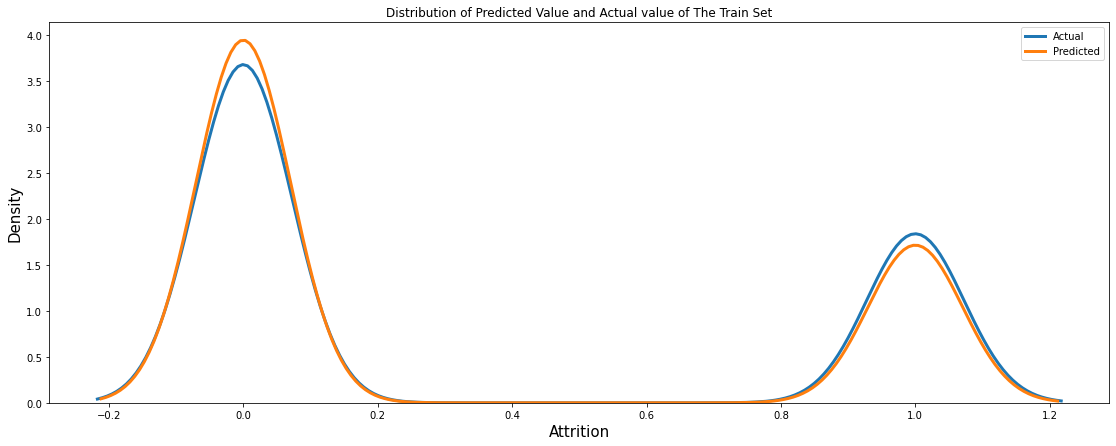

In [146]:
train_pred = lightgbm.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

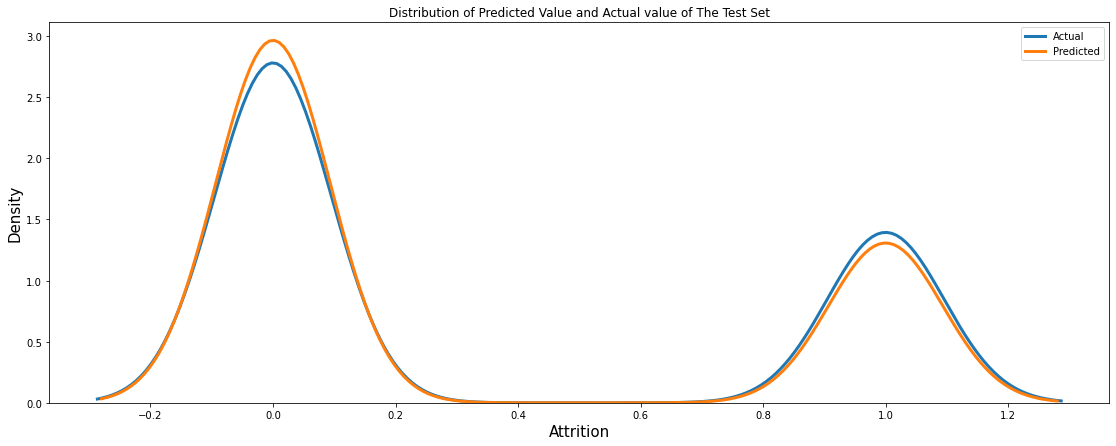

In [147]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

## Hyperparameter Tuning

### XGBoostClassifier

In [148]:
xgboost_ = XGBClassifier()

dist_xgboost = dict(booster=["gbtree", "gblinear"],
                   eta=[0.1, 0.3, 0.5, 0.7],
                   sampling_method=["uniform", "subsample"])

clf_xgboost = RandomizedSearchCV(xgboost_, dist_xgboost, random_state=0)
check_best_xgboost = clf_xgboost.fit(X_train, y_train)
best_params_xgboost = check_best_xgboost.best_params_
best_params_xgboost

[16:50:26] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sampling_method" } are not used.

[16:50:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sampling_method" } are not used.

[16:50:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sampling_method" } are not used.

[16:50:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sampling_method" } are not used.

[16:50:27] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-03de431ba26204c4d-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "sampling_


10 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\user\anaconda3\lib\site-packages\xgboost\sklearn.py", line 1516, in fit
    self._Booster = train(
  File "C:\Users\user\anaconda3\lib\site-packages\xgboost\core.py", line 620, in inner_f
    return func(**kwargs)
  File "C:\Users\user\anaconda3\lib\site-packages\xgboost\training.py"

{'sampling_method': 'uniform', 'eta': 0.3, 'booster': 'gbtree'}

In [149]:
xgboost = XGBClassifier(**best_params_xgboost)
model = xgboost.fit(X_train, y_train)

accuracy_xgboost = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_xgboost = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_xgboost = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_xgboost = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_xgboost = cross_val_score(xgboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_xgboost_best = pd.DataFrame({
    "Accuracy" : accuracy_xgboost, 
    "Precision": precision_xgboost,
    "Recall" : recall_xgboost, 
    "f1Score" : f1_xgboost,
    "ROCAUC" : roc_auc_xgboost
})

result_xgboost_best

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.821124   0.744799  0.694696  0.718876  0.881208
1  0.814310   0.742340  0.679847  0.709720  0.877611
2  0.804940   0.713506  0.678340  0.695479  0.870027
3  0.810822   0.731988  0.663185  0.695890  0.869897
4  0.797614   0.738827  0.647491  0.690150  0.863513

In [150]:
y_pred = xgboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.88      0.86      1955
           1       0.75      0.68      0.71       980

    accuracy                           0.82      2935
   macro avg       0.80      0.78      0.79      2935
weighted avg       0.81      0.82      0.81      2935



<AxesSubplot:>

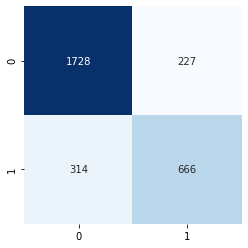

In [151]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

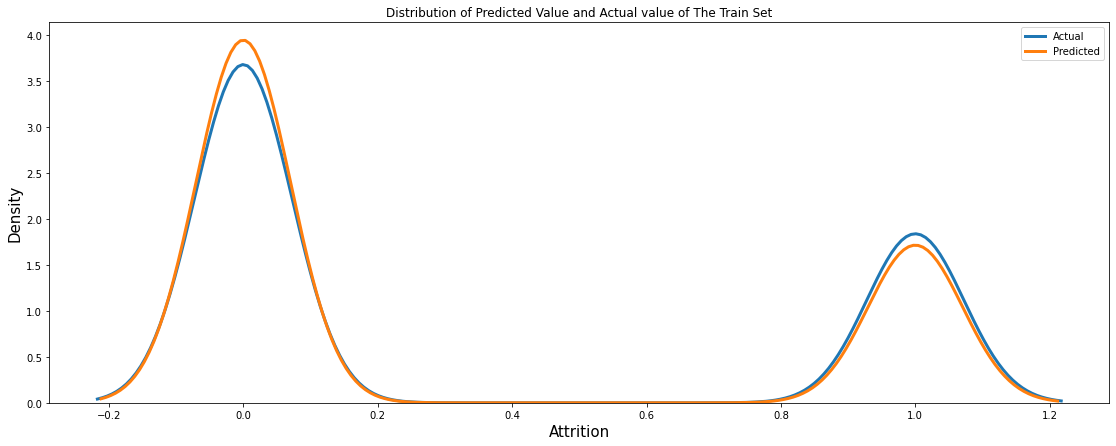

In [152]:
train_pred = lightgbm.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

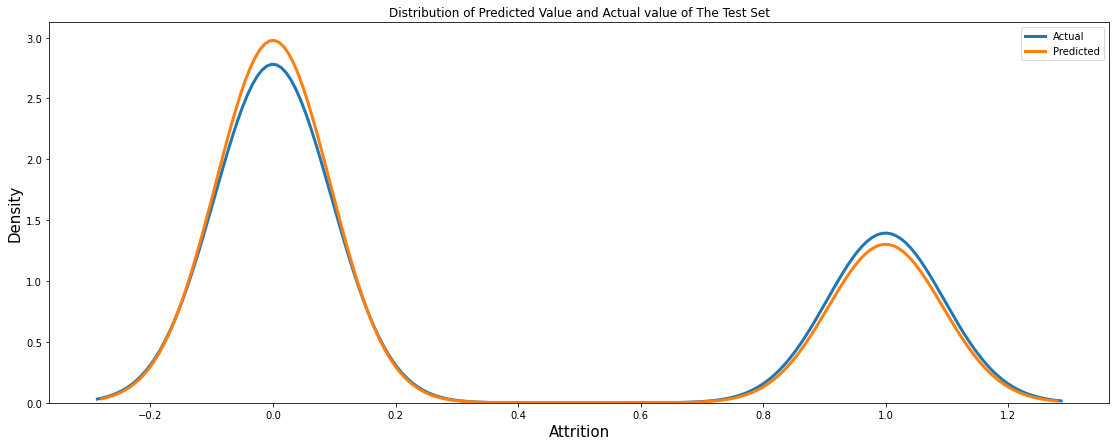

In [153]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Adaboost Classifier

In [154]:
adaboost = AdaBoostClassifier()

dist_ada = dict(base_estimator=[DecisionTreeClassifier() , XGBClassifier()],
                        n_estimators=[25,50,75,100],
                        learning_rate=[0.01, 0.1, 0.5, 1.0],
                        algorithm=['SAMME', 'SAMME.R'])

clf_ada = RandomizedSearchCV(adaboost , dist_ada, random_state=0)
check_best_ada = clf_ada.fit(X_train, y_train)
best_params_ada = check_best_ada.best_params_
best_params_ada

{'n_estimators': 100,
 'learning_rate': 0.5,
 'base_estimator': DecisionTreeClassifier(),
 'algorithm': 'SAMME.R'}

In [155]:
adaboost = AdaBoostClassifier(**best_params_ada)
model = adaboost.fit(X_train, y_train)

accuracy_adaboost = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_adaboost = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_adaboost = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_adaboost = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_adaboost = cross_val_score(adaboost , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_adaboost_best = pd.DataFrame({
    "Accuracy" : accuracy_adaboost, 
    "Precision": precision_adaboost,
    "Recall" : recall_adaboost, 
    "f1Score" : f1_adaboost,
    "ROCAUC" : roc_auc_adaboost
})

result_adaboost_best

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.741908   0.618370  0.624838  0.624759  0.717792
1  0.738501   0.620823  0.604592  0.615483  0.709896
2  0.739779   0.599499  0.613489  0.606641  0.710690
3  0.731572   0.609655  0.561358  0.589967  0.690290
4  0.738816   0.628788  0.619339  0.610801  0.713591

In [156]:
y_pred = adaboost.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.82      0.81      1955
           1       0.63      0.61      0.62       980

    accuracy                           0.75      2935
   macro avg       0.72      0.71      0.72      2935
weighted avg       0.75      0.75      0.75      2935



<AxesSubplot:>

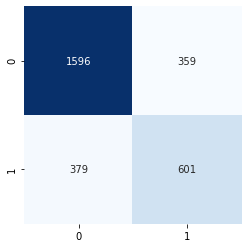

In [157]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

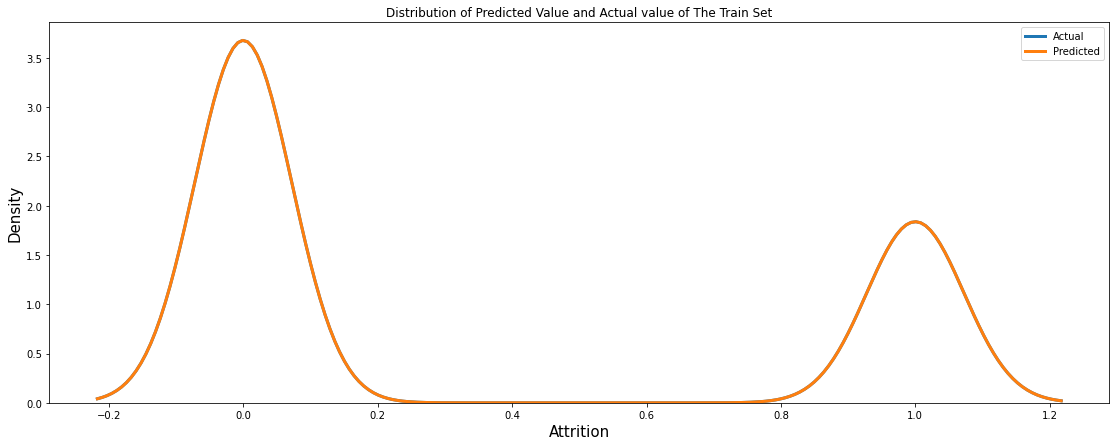

In [158]:
train_pred = adaboost.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

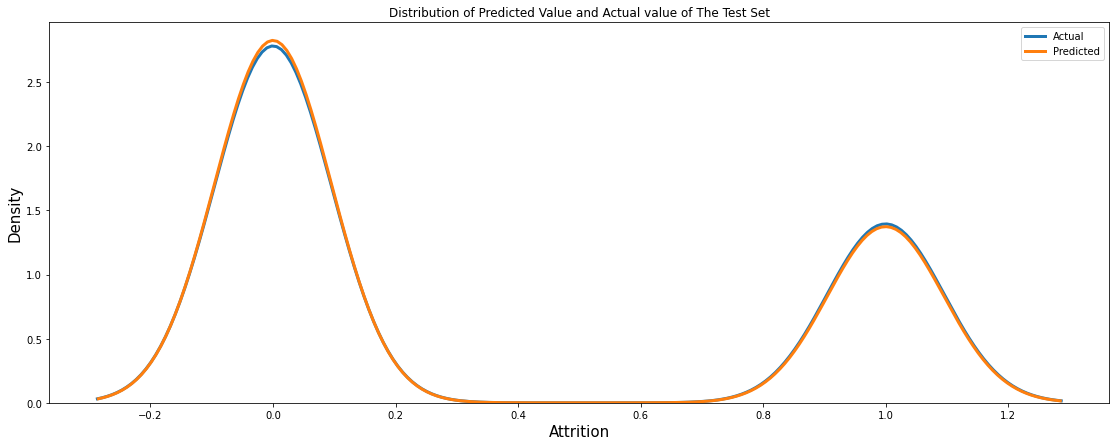

In [159]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### LightGBMClassifier

In [160]:
lightgbm = LGBMClassifier()

dist_lightgbm = dict(boosting_type=["gbdt" , "dart", "goss", "rf"],
                     num_leaves=[25,50,75,100,150],
                     learning_rate=[0.01, 0.05, 0.1],
                     n_estimators=[25, 50, 100, 200],
                     objective=["binary","multiclass"],
                     min_child_samples=[10,20,50,100])

clf_lightgbm = RandomizedSearchCV(lightgbm , dist_lightgbm , random_state=0)
check_best_lightgbm = clf_lightgbm.fit(X_train, y_train)
best_params_lightgbm = check_best_lightgbm.best_params_
best_params_lightgbm


40 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
40 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\user\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 967, in fit
    super().fit(X, _y, sample_weight=sample_weight, init_score=init_score, eval_set=valid_sets,
  File "C:\Users\user\anaconda3\lib\site-packages\lightgbm\sklearn.py", line 748, in fit
    self._Booster = train(
  File "C:\Users\user\anaconda3\lib\site-packages\lightgbm\engine.py", line 271, in train
    booster = Booster(par

{'objective': 'binary',
 'num_leaves': 100,
 'n_estimators': 50,
 'min_child_samples': 50,
 'learning_rate': 0.05,
 'boosting_type': 'goss'}

In [161]:
lgbm = LGBMClassifier(**best_params_lightgbm)
model = lgbm.fit(X_train, y_train)

accuracy_lgbm = cross_val_score(lgbm , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lgbm = cross_val_score(lgbm , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lgbm = cross_val_score(lgbm , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lgbm = cross_val_score(lgbm , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lgbm = cross_val_score(lgbm , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_lgbm_best = pd.DataFrame({
    "Accuracy" : accuracy_lgbm, 
    "Precision": precision_lgbm,
    "Recall" : recall_lgbm, 
    "f1Score" : f1_lgbm,
    "ROCAUC" : roc_auc_lgbm
})

result_lgbm_best

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.815162   0.747445  0.662354  0.702332  0.883350
1  0.823254   0.761702  0.684949  0.721289  0.884371
2  0.811329   0.739067  0.657588  0.695951  0.872525
3  0.809544   0.742033  0.638381  0.686316  0.872292
4  0.809544   0.769679  0.646267  0.702595  0.869318

In [162]:
y_pred = lgbm.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.90      0.87      1955
           1       0.77      0.67      0.72       980

    accuracy                           0.82      2935
   macro avg       0.81      0.79      0.80      2935
weighted avg       0.82      0.82      0.82      2935



<AxesSubplot:>

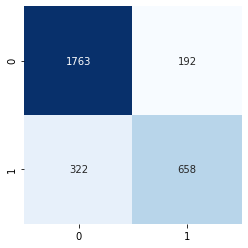

In [163]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

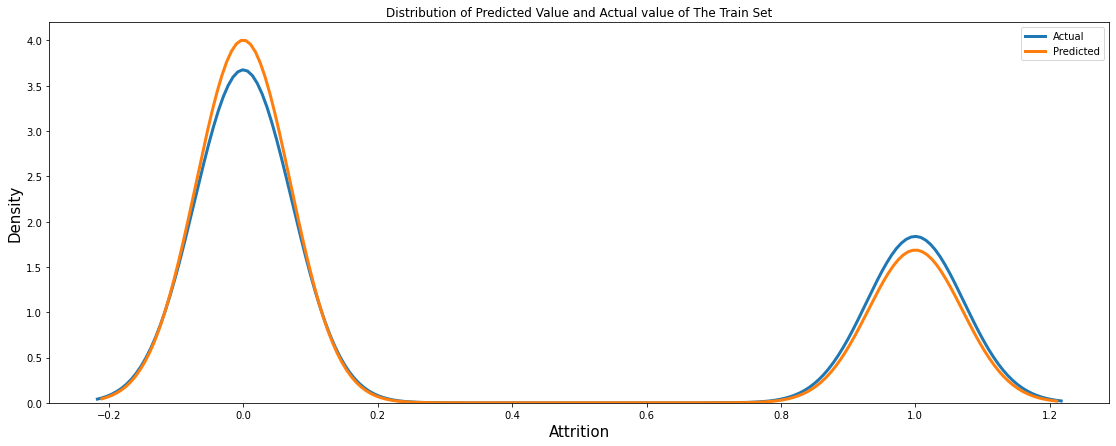

In [164]:
train_pred = lgbm.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

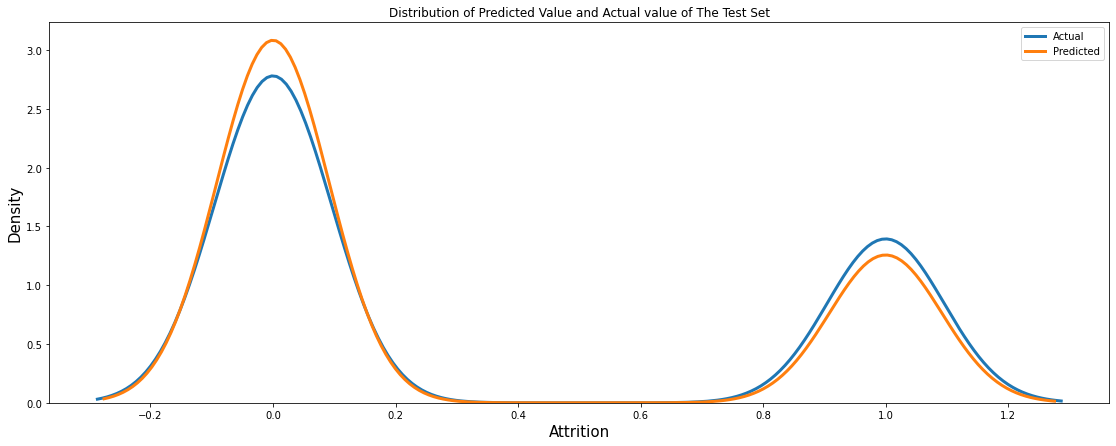

In [165]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

### Random Forest

In [166]:
random_forest = RandomForestClassifier()

dist_rf = dict(n_estimators=range(0,101),
                        criterion=["gini", "entropy", "log_loss"],
                        max_depth=[3,4,5,6],
                        max_features=["sqrt", "log2", None])

clf_rf = RandomizedSearchCV(random_forest , dist_rf , random_state=0)
check_best_rf = clf_rf.fit(X_train, y_train)
best_params_rf = check_best_rf.best_params_
best_params_rf

{'n_estimators': 32,
 'max_features': None,
 'max_depth': 5,
 'criterion': 'log_loss'}

In [167]:
random_forest = RandomForestClassifier(**best_params_rf)
model = random_forest.fit(X_train, y_train)

accuracy_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_rf = cross_val_score(random_forest , X_train , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_rf_best = pd.DataFrame({
    "Accuracy" : accuracy_rf, 
    "Precision": precision_rf,
    "Recall" : recall_rf, 
    "f1Score" : f1_rf,
    "ROCAUC" : roc_auc_rf
})

result_rf_best

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.813032   0.745914  0.657180  0.704918  0.877852
1  0.816865   0.746744  0.663265  0.706122  0.882534
2  0.810051   0.740240  0.640726  0.686233  0.867224
3  0.806135   0.742857  0.622715  0.673396  0.863075
4  0.796336   0.767081  0.602203  0.674847  0.861008

In [169]:
y_pred = random_forest.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1955
           1       0.77      0.65      0.70       980

    accuracy                           0.82      2935
   macro avg       0.80      0.77      0.79      2935
weighted avg       0.81      0.82      0.81      2935



<AxesSubplot:>

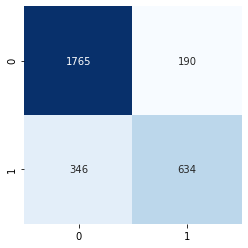

In [170]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

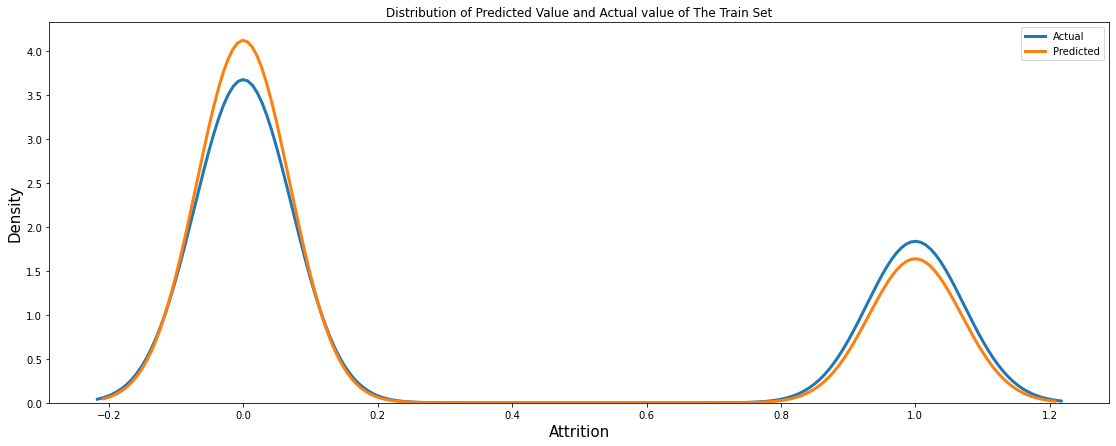

In [171]:
train_pred = random_forest.predict(X_train)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

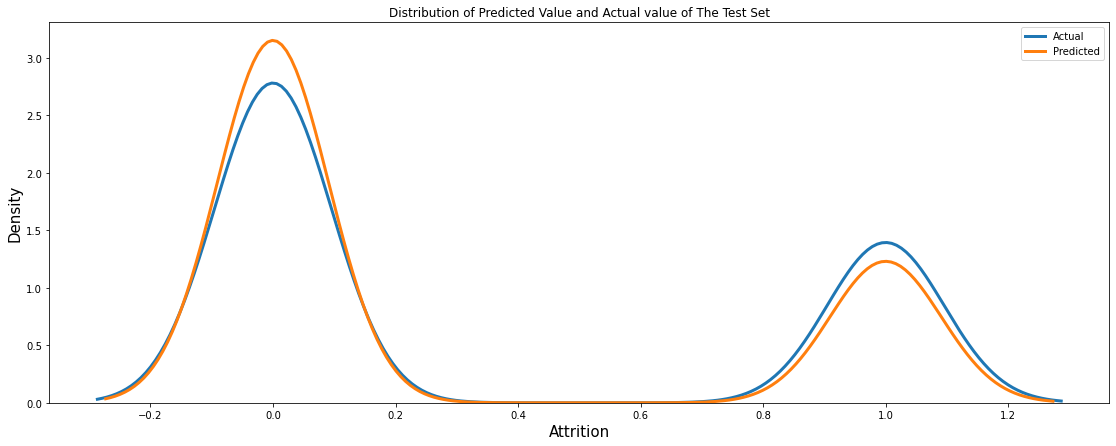

In [172]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

## Best Features of LightGBM with SHAP

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray


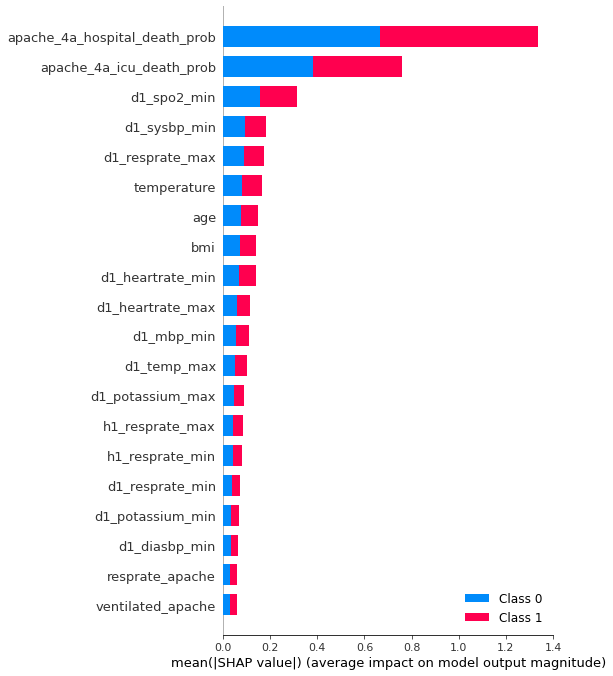

In [174]:
lightgbm = LGBMClassifier(**best_params_lightgbm)
model = lightgbm.fit(X_train, y_train)

shap_values = shap.TreeExplainer(model).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

In [175]:
X_train_k = X_train[['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'd1_spo2_min', 'd1_sysbp_min', 'age']]
X_test_k = X_test[['apache_4a_icu_death_prob', 'apache_4a_hospital_death_prob', 'd1_spo2_min', 'd1_sysbp_min', 'age']]

In [176]:
lightgbm = LGBMClassifier(**best_params_lightgbm)
model = lightgbm.fit(X_train_k, y_train)

accuracy_lgbm = cross_val_score(lightgbm , X_train_k , y_train , cv=cross_validation , scoring="accuracy" , n_jobs=-1)
precision_lgbm = cross_val_score(lightgbm , X_train_k , y_train , cv=cross_validation , scoring="precision" , n_jobs=-1)
recall_lgbm = cross_val_score(lightgbm , X_train_k , y_train , cv=cross_validation , scoring="recall" , n_jobs=-1)
f1_lgbm = cross_val_score(lightgbm , X_train_k , y_train , cv=cross_validation , scoring="f1" , n_jobs=-1)
roc_auc_lgbm = cross_val_score(lightgbm , X_train_k , y_train , cv=cross_validation , scoring="roc_auc" , n_jobs=-1)

result_lgbm_best = pd.DataFrame({
    "Accuracy" : accuracy_lgbm, 
    "Precision": precision_lgbm,
    "Recall" : recall_lgbm, 
    "f1Score" : f1_lgbm,
    "ROCAUC" : roc_auc_lgbm
})

result_lgbm_best

Accuracy  Precision    Recall   f1Score    ROCAUC
0  0.804514   0.721751  0.661061  0.690074  0.871967
1  0.809199   0.740000  0.660714  0.698113  0.873130
2  0.795997   0.715976  0.627756  0.668970  0.858877
3  0.793353   0.719189  0.601828  0.655295  0.857409
4  0.786536   0.743827  0.589963  0.658020  0.853736

In [178]:
y_pred = lightgbm.predict(X_test_k)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1955
           1       0.77      0.64      0.70       980

    accuracy                           0.81      2935
   macro avg       0.80      0.77      0.78      2935
weighted avg       0.81      0.81      0.81      2935



<AxesSubplot:>

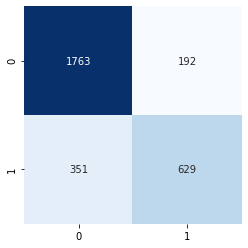

In [179]:
conf_mat = confusion_matrix(y_test, y_pred)
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]
sns.heatmap(conf_mat, square=True, annot=True, cmap='Blues', fmt='d', cbar=False)

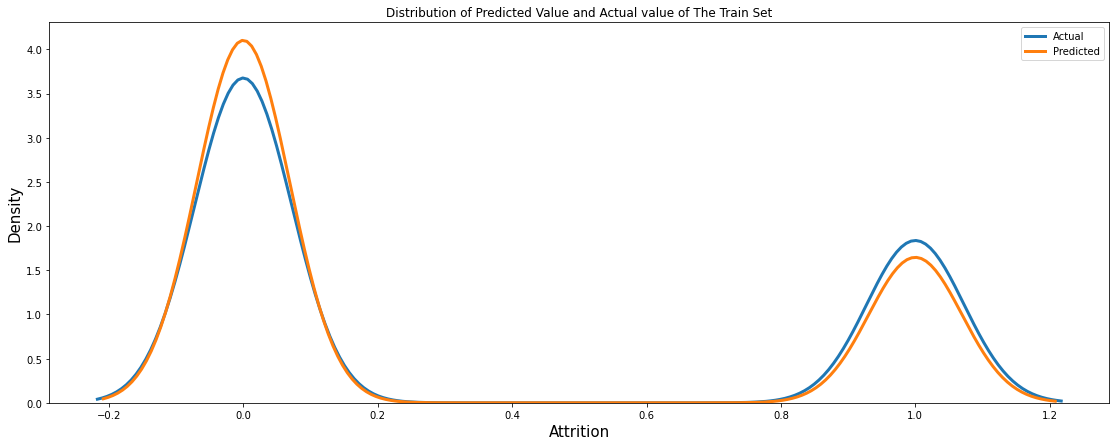

In [180]:
train_pred = lightgbm.predict(X_train_k)
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_train, label = "Actual", linewidth = 3)
sns.kdeplot(x = train_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Train Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

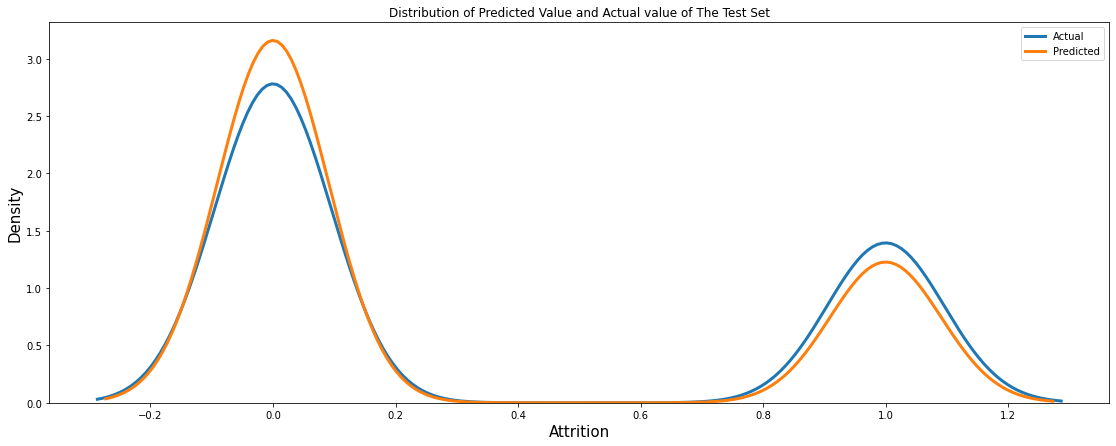

In [181]:
plt.figure(figsize = (19, 7))
sns.kdeplot(data = dataset, x = y_test, label = "Actual", linewidth = 3)
sns.kdeplot(x = y_pred, label = "Predicted", linewidth = 3)
plt.title("Distribution of Predicted Value and Actual value of The Test Set")
plt.xlabel("Attrition", size = 15)
plt.ylabel("Density", size = 15)
plt.legend()
plt.show()

In [182]:
pickle.dump(model, open('model.pkl','wb'))